<a href="https://colab.research.google.com/github/TingyiWei2024/Wastewater-Data-Analysis/blob/main/NL_Wastewater_Surveillance_for_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 模型大纲

I. 目标  
   1. 在“时间—空间”维度上量化 SARS-CoV-2 在污水中的浓度演变  
   2. 利用多种监督学习算法预测“爆发期”“潜伏期”“无病毒期”及高风险区域  

II. 数据输入  
   A. 可用数据
   1. 周四采样的 CP/mL（Cosca filter）  
   2. 时间信息：采样日期（对齐到每周星期四）  
   3. 空间信息：经纬度、最近诊所距离、诊所密度、可达性指数  
   4. 环境变量：气温、降雨量、pH、水流量  
   5. 社会经济变量：人口服务量、#疫苗接种率、低收入率、老年人口比例、弱势群体占比 （部分为全省数据暂不输入）
   #6. 流行病学指标：同期确诊病例数、检测阳性率  
   #7. 公共卫生干预：封锁/解封与检测策略时间节点  


   B. 特征工程  
   1. 时间特征：周数、月、季节、节假日标志、cpml_lag1/2、rolling_mean3  
   2. 空间特征：lat/lon、nearest_clinic_dist、clinic_density_5km、accessibility_index、spatial_lag_cpml  
   3. 交互特征：region×lag、clinic_density×rolling_mean

III. 时空对比探索分析  
   1. **时间维度对比**  
      - 周频序列分解（趋势/季节性/残差）  
      - ARIMA/SARIMA vs. Prophet vs. LSTM：比较 MUN 与 StJ 在趋势与波动模式上的异同  
   2. **空间维度对比**  
      - 克里金插值 / RBF 插值：生成同一周的空间热力图  
      - 统计量对比：各周两个点的 CP/mL 差值 & 比例  
   3. **时空混合效应模型**  
      - GLMM / 贝叶斯时空模型：把区域和时间当随机效应，量化它们的边际贡献  

IV. 缺失与增强  ？？？
   1. 对齐到“周四”：`df.resample('W-THU')`  
   2. 小量缺失：线性插值 `.interpolate()`  
   3. 不平衡/大面积缺失：GMM 回归增强 或 SMOTE/SMOGN  

V.  机器学习模型比对  
   1. **支持向量机 (SVM)**  
   2. **分类回归树 (CART)**  
   3. **随机森林 (RF)**  
   4. **梯度提升机 (GBM)**  
   5. **人工神经网络 (ANN/LSTM/ST-CNN)**

VI. 评估与解释  
   1. 交叉验证策略：留一周、留一区  
   2. 性能指标：Ｒ２/RMSE、ROC-AUC/Recall  
   3. 解释性分析：PDP、SHAP、ALE

VII. 决策支持  
   - 高风险预警地图  
   - 干预资源调度建议  


# 0. data input


In [ ]:
## Data loading
!pip install openpyxl xlrd --quiet

# Connect Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. loading data for st'johns and mun
import pandas as pd

base_path = '/content/drive/MyDrive/NL Wastewater'
mun_path    = f'{base_path}/mun.xlsx'
stj_path    = f'{base_path}/Stjohns.xlsx'
clinics_path  = f'{base_path}/St Johns clinics address.xlsx'


mun_df = pd.read_excel(mun_path, sheet_name=0, engine='openpyxl')
stj_df = pd.read_excel(stj_path, sheet_name=0, engine='openpyxl')
clinics_df  = pd.read_excel(clinics_path, sheet_name=0, engine='openpyxl')

# 2. 预处理：检查和统一列名、日期格式、缺失值
def preprocess(df, parse_dates=False):
    df = df.copy()
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace(r'[^\w_]', '', regex=True))
    if parse_dates:
        for c in df.columns:
            if 'date' in c or 'time' in c:
                df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

mun_df   = preprocess(mun_df, parse_dates=True)
stj_df   = preprocess(stj_df, parse_dates=True)
clinics_df = preprocess(clinics_df, parse_dates=False)

# output
print("=== MUN Data ===")
print(mun_df.info())
print(mun_df.isna().sum().sort_values(ascending=False).head(10))

print("\n=== St. John's Data ===")
print(stj_df.info())
print(stj_df.isna().sum().sort_values(ascending=False).head(10))

print("\n=== Clinics Data ===")
print(clinics_df.columns.tolist())
print(clinics_df.head())

mun_df.head(), stj_df.head(), clinics_df.head()

=== MUN Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   1307 non-null   datetime64[ns]
 1   sample_location                        1307 non-null   object        
 2   time                                   0 non-null      datetime64[ns]
 3   sample_id                              145 non-null    object        
 4   positive_or_negative                   152 non-null    object        
 5   cpml                                   144 non-null    float64       
 6   flow_normalized_cpml_per_m3d           0 non-null      float64       
 7   population_normalized_cpml_per_person  5 non-null      float64       
 8   sample_type                            145 non-null    object        
 9   composite_type                         145 non

(        date sample_location time     sample_id positive_or_negative  cpml  \
 0 2021-08-30             MUN  NaT           NaN                  NaN   NaN   
 1 2021-08-31             MUN  NaT           NaN                  NaN   NaN   
 2 2021-09-01             MUN  NaT           NaN                  NaN   NaN   
 3 2021-09-02             MUN  NaT  4400-9-MH1-1       Low Confidence   3.0   
 4 2021-09-03             MUN  NaT           NaN                  NaN   NaN   
 
    flow_normalized_cpml_per_m3d  population_normalized_cpml_per_person  \
 0                           NaN                                    NaN   
 1                           NaN                                    NaN   
 2                           NaN                                    NaN   
 3                           NaN                               0.001765   
 4                           NaN                                    NaN   
 
     sample_type composite_type  composite_duration_h  air_temp_oc  \
 0

In [ ]:
clinics_df.rename(
    columns={
        'latitude__n': 'latitude',
        'longitude__w': 'longitude'
    },
    inplace=True
)

# 验证
print("重命名后的 Clinics 列：", clinics_df.columns.tolist())

重命名后的 Clinics 列： ['place_title', 'address', 'latitude', 'longitude']




---



# 1. Cosca filter和Composite相关性模拟
- cpml可用数据不足1000个，mun144个，stj501个存在重复测样（瞬时和平均）
- 8个点可用数据
- 用mun建立cosco和composite样本转化模型（问题1）
- 见VScode (未调试好)


In [ ]:
# create features

# 1. MUN state
mun_input = mun_df[[
    'date',
    'cpml',
    'air_temp_oc',
    'precip_as_rain_in_last_24_hrs_mm',
    'population_serviced'
]].copy()

# 丢弃 cpml 缺失
mun_input = mun_input.dropna(subset=['cpml'])

# 设日期为索引并排序
mun_input = (
    mun_input
    .set_index('date')
    .sort_index()
)

# 2. St. John’s state
stj_input = stj_df[[
    'date',
    'cpml',
    'air_temp_oc',
    'precip_as_rain_in_last_24_hrs_mm',
    'wastewater_flow_m3d',
    'population_serviced'
]].copy()

stj_input = stj_input.dropna(subset=['cpml'])
stj_input = (
    stj_input
    .set_index('date')
    .sort_index()
)

# 3. 查看结果
print("MUN input samples：")
print(mun_input.head(), mun_input.index.min(), mun_input.index.max())

print("\nSt. John’s input samples：")
print(stj_input.head(), stj_input.index.min(), stj_input.index.max())


MUN 输入样例：
            cpml  air_temp_oc  precip_as_rain_in_last_24_hrs_mm  \
date                                                              
2021-09-02   3.0         19.0                               5.4   
2021-09-09   0.0         18.0                               2.8   
2021-09-16   3.0         13.0                               0.3   
2021-09-23   0.0         15.0                               0.2   
2021-09-29   0.0         16.0                               7.1   

            population_serviced  
date                             
2021-09-02               1700.0  
2021-09-09               3000.0  
2021-09-16               3000.0  
2021-09-23               2500.0  
2021-09-29               2500.0   2021-09-02 00:00:00 2025-03-28 00:00:00

St. John’s 输入样例：
            cpml  air_temp_oc  precip_as_rain_in_last_24_hrs_mm  \
date                                                              
2021-04-20   0.0          1.0                               0.6   
2021-04-22   0.0       



---



---



# 2. MUN和stjohns时空地区对比

## 2.1 输入特征

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.regression.mixed_linear_model import MixedLM
from math import radians, sin, cos, sqrt, atan2, pi

# 3. 定义文件路径并读取 Excel
base_path     = '/content/drive/MyDrive/NL Wastewater'
mun_path      = f'{base_path}/mun.xlsx'
stj_path      = f'{base_path}/Stjohns.xlsx'
clinics_path  = f'{base_path}/St Johns clinics address.xlsx'

mun_df     = pd.read_excel(mun_path,       engine='openpyxl')
stj_df     = pd.read_excel(stj_path,       engine='openpyxl')
clinics_df = pd.read_excel(clinics_path,   engine='openpyxl')

# 4. 统一列名 & 解析日期
def preprocess(df, parse_dates=False):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(' ', '_')
          .str.replace(r'[^\w_]', '', regex=True)
    )
    if parse_dates:
        for c in df.columns:
            if 'date' in c or 'time' in c:
                df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

mun_df     = preprocess(mun_df,     parse_dates=True)
stj_df     = preprocess(stj_df,     parse_dates=True)
clinics_df = preprocess(clinics_df, parse_dates=False)

# 5. 重命名诊所表经纬度列
clinics_df.rename(
    columns={'latitude__n': 'latitude', 'longitude__w': 'longitude'},
    inplace=True
)

# 6. 筛选 Cosca filter 样本 & 丢弃 cpml 缺失
print("原始 stj sample_type 唯一值：", stj_df['sample_type'].unique())
stj_df = stj_df[ stj_df['sample_type'].str.contains('cosca', case=False, na=False) ]
print("筛选后 stj sample_type 唯一值：", stj_df['sample_type'].unique())
mun_df = mun_df.dropna(subset=['cpml'])
stj_df = stj_df.dropna(subset=['cpml'])

# 7. 构建按日期索引的输入集
mun_input = (
    mun_df[['date', 'cpml', 'air_temp_oc', 'precip_as_rain_in_last_24_hrs_mm', 'population_serviced']]
    .set_index('date')
    .sort_index()
)
stj_input = (
    stj_df[['date', 'cpml', 'air_temp_oc', 'precip_as_rain_in_last_24_hrs_mm',
            'wastewater_flow_m3d', 'population_serviced']]
    .set_index('date')
    .sort_index()
)

# 8. 周四对齐 & 插值补全
mun_weekly = mun_input.resample('W-THU').mean().interpolate()
stj_weekly = stj_input.resample('W-THU').mean().interpolate()

# 9. 合并成面板数据
mun_weekly['region'] = 'MUN'
stj_weekly['region'] = 'STJ'
panel = pd.concat([mun_weekly, stj_weekly]) \
          .reset_index() \
          .rename(columns={'index':'date'})

# 10. 时间特征工程
panel['weekofyear'] = panel['date'].dt.isocalendar().week
panel['month']      = panel['date'].dt.month
panel['quarter']    = panel['date'].dt.quarter
panel['cpml_lag1']  = panel.groupby('region')['cpml'].shift(1)
panel['cpml_lag2']  = panel.groupby('region')['cpml'].shift(2)
panel['cpml_roll3'] = (
    panel.groupby('region')['cpml']
         .rolling(3).mean()
         .reset_index(0, drop=True)
)


# 11. 空间特征计算函数
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

# 12. 计算空间特征：nearest_clinic_dist, clinic_density_5km, accessibility_index
region_coords = {
    'MUN': (47.572564, -52.727367),
    'STJ': (47.556990, -52.708820),
}
# 提取每个 region 的 population_serviced
pop_map = panel.dropna(subset=['population_serviced']) \
               .groupby('region')['population_serviced'] \
               .first().to_dict()

spatial_feats = []
for region, (lat0, lon0) in region_coords.items():
    dists = clinics_df.apply(
        lambda r: haversine(lat0, lon0, r['latitude'], r['longitude']),
        axis=1
    )
    nearest = float(dists.min())
    density = float((dists <= 5).sum() / (pi * 5**2))
    pop     = pop_map.get(region, np.nan)
    acc     = float((1 / dists.replace(0, np.nan)).sum() / pop) if pop and not np.isnan(pop) else np.nan
    spatial_feats.append({
        'region': region,
        'nearest_clinic_dist': nearest,
        'clinic_density_5km': density,
        'accessibility_index': acc
    })

spatial_df = pd.DataFrame(spatial_feats)
panel = panel.merge(spatial_df, on='region', how='left')

# 最终面板
panel.head()

原始 stj sample_type 唯一值： [nan 'Composite' 'Compostie' 'COSCa Filter']
筛选后 stj sample_type 唯一值： ['COSCa Filter']


,date,cpml,air_temp_oc,precip_as_rain_in_last_24_hrs_mm,population_serviced,region,wastewater_flow_m3d,weekofyear,month,quarter,cpml_lag1,cpml_lag2,cpml_roll3,nearest_clinic_dist,clinic_density_5km,accessibility_index
0,2021-09-02,3.0,19.0,5.4,1700.0,MUN,NaN,35,9,3,NaN,NaN,NaN,0.884441,0.305577,0.007624
1,2021-09-09,0.0,18.0,2.8,3000.0,MUN,NaN,36,9,3,3.0,NaN,NaN,0.884441,0.305577,0.007624
2,2021-09-16,3.0,13.0,0.3,3000.0,MUN,NaN,37,9,3,0.0,3.0,2.0,0.884441,0.305577,0.007624
3,2021-09-23,0.0,15.0,0.2,2500.0,MUN,NaN,38,9,3,3.0,0.0,1.0,0.884441,0.305577,0.007624
4,2021-09-30,0.0,16.0,7.1,2500.0,MUN,NaN,39,9,3,0.0,3.0,1.0,0.884441,0.305577,0.007624


基础变量：cpml、air_temp_oc、precip_as_rain_in_last_24_hrs_mm、population_serviced、以及 St. John’s 的 wastewater_flow_m3d

时间特征：weekofyear、month、quarter、cpml_lag1、cpml_lag2、cpml_roll3

空间特征：nearest_clinic_dist（最近诊所距离）、clinic_density_5km（5 km 范围内诊所密度）、accessibility_index（可达性指数）



---

1. **`cpml_lag1`（一阶滞后）**

   * 含义：当前周的特征里加入“上一周”的 CP/mL 值。
   * 作用：让模型知道上一周的病毒浓度水平，从而捕获一阶自相关（如果上周浓度高，本周也倾向高）。

2. **`cpml_lag2`（二阶滞后）**

   * 含义：在特征里加入“上两周”（二周前）的 CP/mL 值。
   * 作用：进一步把更远一点的历史信息纳入，帮助模型判断更长的延迟效应（例如：潜伏期、滞后排放造成的波动）。

3. **`cpml_roll3`（3 周滚动平均）**

   * 含义：对当前周及其前两周的 CP/mL 做平均（窗口宽度 = 3 周）。
   * 作用：平滑短期随机噪声，突出更稳定的趋势；还可以降低极端值的影响，让模型关注“趋势”而非一时的峰值或波动。





---



### 2.1 输入特征解析


## 一、输入特征包括

在最终送入模型前，我们为每个“周四采样”的站点准备了一行数据，这行数据包含以下几大类特征：

1. **环境气象特征**

   * `air_temp_oc`：当周四当天的气温（℃）
   * `precip_as_rain_in_last_24_hrs_mm`：前 24 小时总降雨量（mm）

2. **水量与服务人口**

   * `wastewater_flow_m3d`：污水流量（立方米/天）
   * `population_serviced`：该站点服务的人口数

3. **时间序列特征**

   * `weekofyear`：一年中第几周（1–53）
   * `month`：月份（1–12）
   * `quarter`：季度（1–4）
   * `cpml_lag1`、`cpml_lag2`：前一周、前两周的 CP/mL 浓度
   * `cpml_roll3`：过去 3 周平均 CP/mL

4. **空间医疗可达性特征**

   * `nearest_clinic_dist`：该区域到最近诊所的直线距离（km）
   * `clinic_density_5km`：5 km 范围内诊所数量除以圆面积（个/km²）
   * `accessibility_index`：所有诊所“1/距离”之和再除以服务人口（人均可达性）

5. **类别特征**

   * `region`：监测站点所属区域（MUN 或 STJ）







---



## 2.2 时空模型

III. 时空对比探索分析  
   1. **时间维度对比**  
      - 周频序列分解（趋势/季节性/残差）  
      - ARIMA/SARIMA vs. Prophet vs. LSTM：比较 MUN 与 StJ 在趋势与波动模式上的异同  
   2. **空间维度对比**  
      - 克里金插值 / RBF 插值：生成同一周的空间热力图  
      - 统计量对比：各周两个点的 CP/mL 差值 & 比例  
   3. **时空混合效应模型**  
      - GLMM / 贝叶斯时空模型：把区域和时间当随机效应，量化它们的边际贡献

Panel regions: ['MUN' 'STJ']


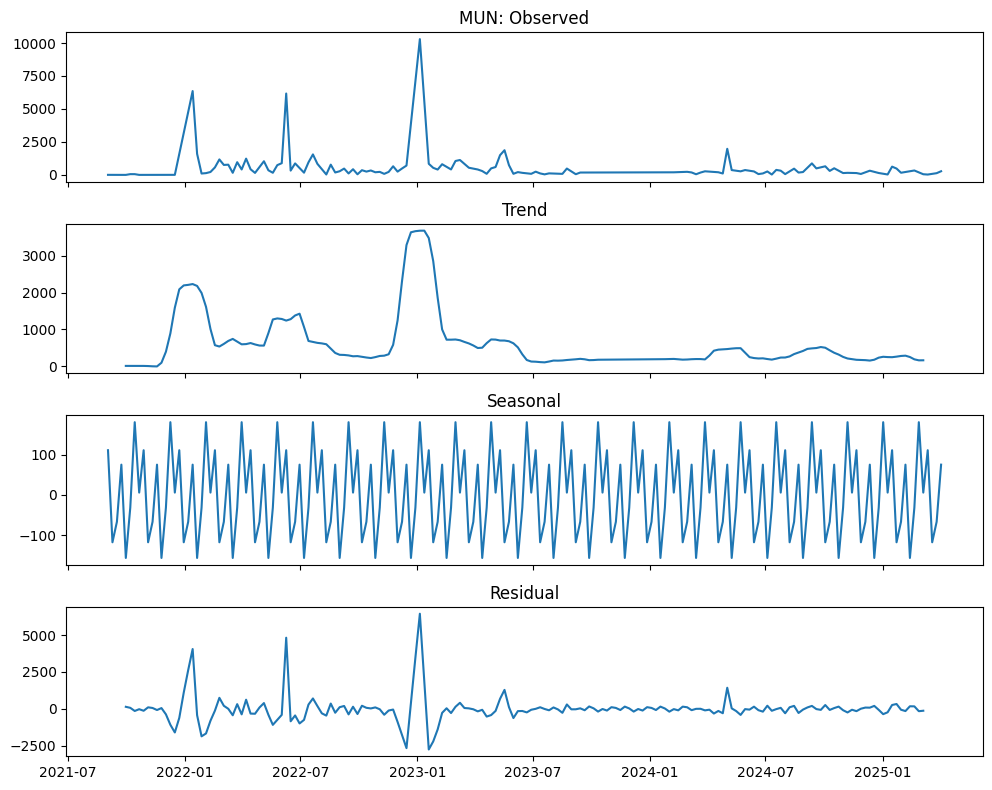

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1r9s566/zev8wg9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1r9s566/c_bd8la1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54914', 'data', 'file=/tmp/tmpg1r9s566/zev8wg9a.json', 'init=/tmp/tmpg1r9s566/c_bd8la1.json', 'output', 'file=/tmp/tmpg1r9s566/prophet_modelfgy2hhln/prophet_model-20250516114425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MUN ARIMA AIC: 3107.0332488157737


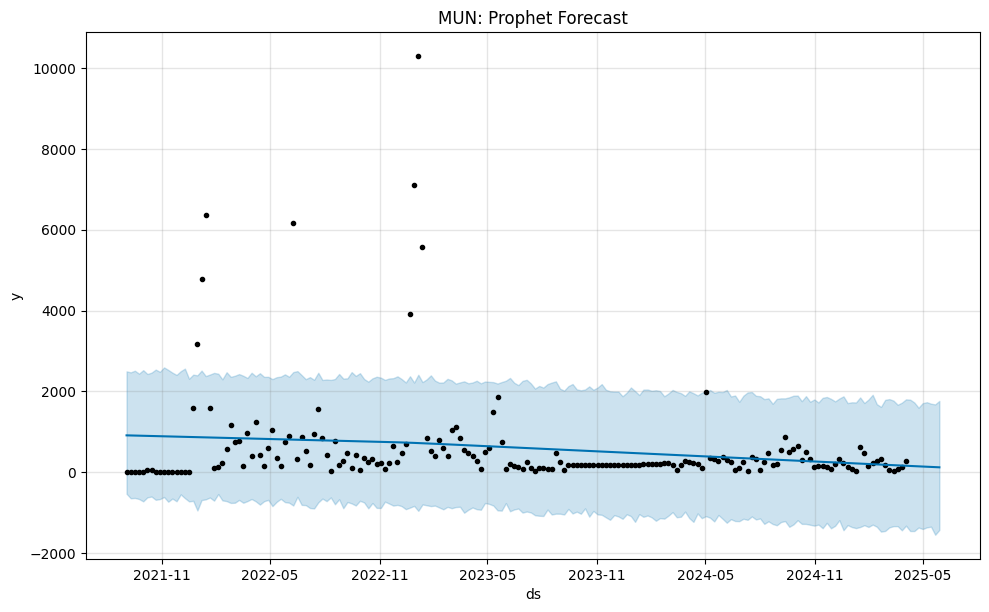

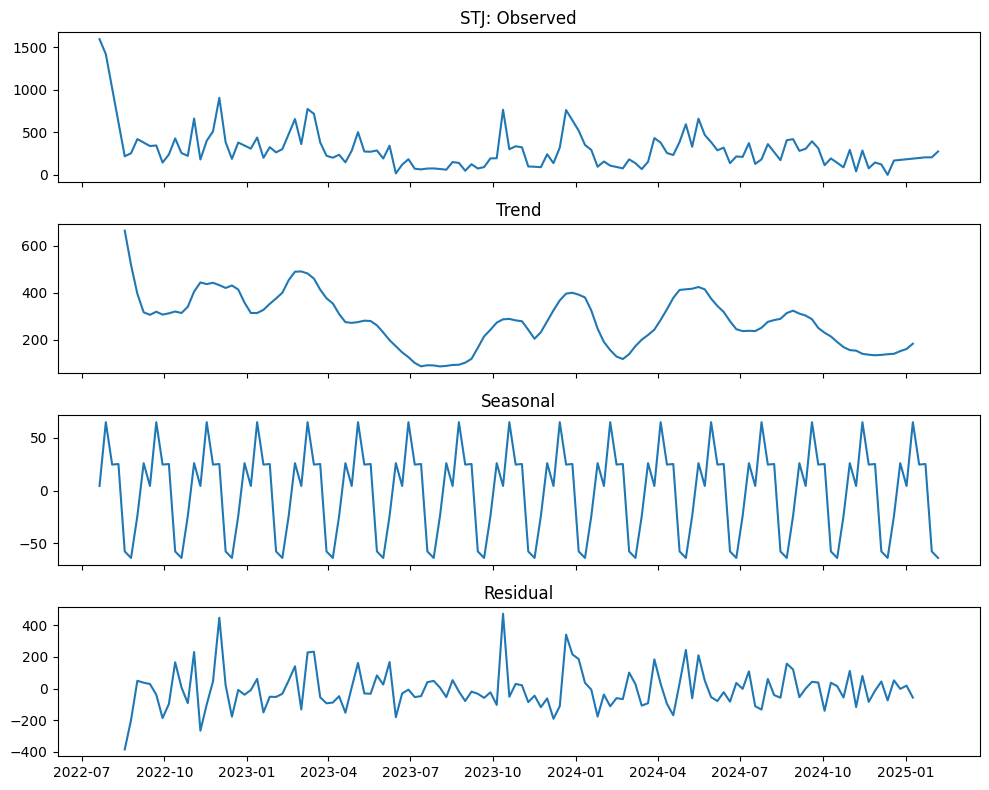

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1r9s566/c8ym9sdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1r9s566/y_gkgv77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73485', 'data', 'file=/tmp/tmpg1r9s566/c8ym9sdt.json', 'init=/tmp/tmpg1r9s566/y_gkgv77.json', 'output', 'file=/tmp/tmpg1r9s566/prophet_modelyeb2mijp/prophet_model-20250516114427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


STJ ARIMA AIC: 1773.6324789713215


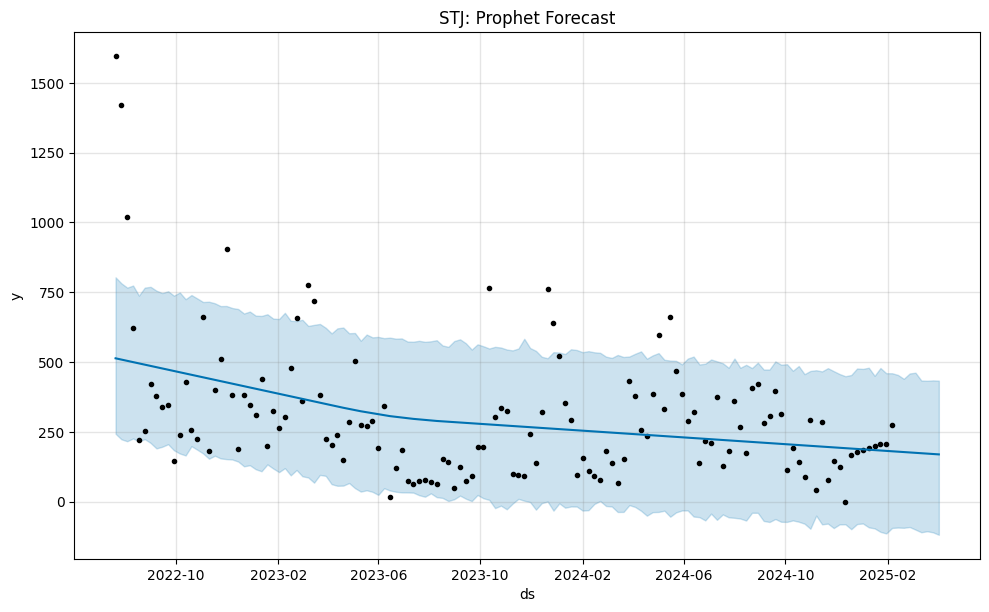

Wide columns: ['MUN', 'STJ']


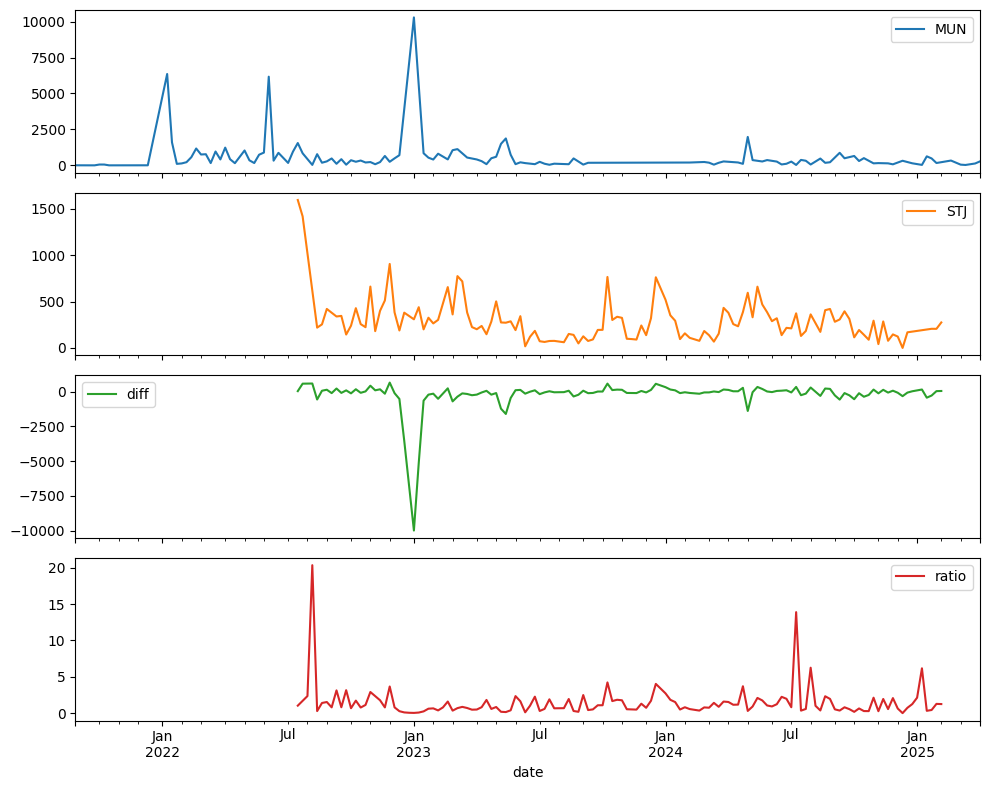

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: cpml       
No. Observations:  322     Method:             REML       
No. Groups:        2       Scale:              935812.1828
Min. group size:   134     Log-Likelihood:     -2663.3790 
Max. group size:   188     Converged:          Yes        
Mean group size:   161.0                                  
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    649.177  167.862  3.867 0.000 320.173 978.182
weeknum       -7.396    3.458 -2.139 0.032 -14.173  -0.618
region Var 32443.330   56.295                             



In [ ]:

#!pip install prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.regression.mixed_linear_model import MixedLM
from math import radians, sin, cos, sqrt, atan2, pi

# —— 2. 时空对比探索分析（模块 III） ——

# 1. 检查 panel 中的 region
print("Panel regions:", panel['region'].unique())

# 2. 时间维度对比
for region in panel['region'].unique():
    df = panel[panel.region == region].set_index('date')

    res = seasonal_decompose(df['cpml'], model='additive', period=8) # 趋势/季节性/残差分解（period=8 暂定为2个月）
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(res.observed);  axes[0].set_title(f'{region}: Observed')
    axes[1].plot(res.trend);     axes[1].set_title('Trend')
    axes[2].plot(res.seasonal);  axes[2].set_title('Seasonal')
    axes[3].plot(res.resid);     axes[3].set_title('Residual')
    plt.tight_layout(); plt.show()

    # ARIMA 模型
    try:
        arima_model = ARIMA(df['cpml'], order=(1,0,1)).fit()
        print(region, "ARIMA AIC:", arima_model.aic)
    except Exception as e:
        print(region, "ARIMA error:", e)

    # Prophet 模型
    prophet_df = df['cpml'].reset_index().rename(columns={'date':'ds','cpml':'y'})
    m = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=8, freq='W-THU')
    forecast = m.predict(future)
    fig2 = m.plot(forecast)
    plt.title(f'{region}: Prophet Forecast')
    plt.show()

# 3. 空间维度对比：差值 & 比例
df_wide = panel.pivot_table(index='date', columns='region', values='cpml', aggfunc='mean')
print("Wide columns:", df_wide.columns.tolist())

# 确认至少包含两个区域
regions_wide = df_wide.columns.tolist()
if len(regions_wide) >= 2:
    reg1, reg2 = regions_wide[:2]
    mun_s = df_wide[reg1]
    stj_s = df_wide[reg2]
    comp = pd.DataFrame({
        reg1:  mun_s,
        reg2:  stj_s,
        'diff': stj_s - mun_s,
        'ratio': stj_s / mun_s.replace(0, np.nan)
    })
    comp.plot(subplots=True, figsize=(10,8))
    plt.tight_layout(); plt.show()
else:
    print("只有一个区域，跳过空间对比。")

# 4. 时空混合效应模型
panel['weeknum'] = panel['date'].dt.isocalendar().week
md = MixedLM.from_formula('cpml ~ weeknum', groups='region', data=panel)
mixed_res = md.fit()
print(mixed_res.summary())

### 2.2 解析

### 找一下：StJ的人口密度分布

整体趋势：无论 MUN 还是 STJ，都呈现随周次增加而整体下降的动向，可能对应人群免疫提升、检测策略变化或干预措施持续奏效。

区域差异：两个区域的平均浓度差异巨大，选址与资源分配时应优先考虑 MUN（基线更高）进行更密集的监测和干预。

### 2.2.1 时空对比模型


## 1. 时间维度对比：趋势 & 波动模式

* **季节分解（`seasonal_decompose`）**

  * **用途**：把原始序列分成 “趋势（Trend）/ 季节性（Seasonal）/ 残差（Residual）” 三部分。
  * **原因**：数据里长期走向 vs 重复周期 vs 突发波动，帮助直观对比 MUN 和 STJ 的差异。

* **ARIMA (1,0,1)**

  * **用途**：用自回归 + 移动平均结构拟合平稳后的残差项。
  * **原因**：

    1. **可解释**：“上周浓度对本周的线性贡献”。
    - 自回归阶数 AR =1 "上周影响"
    - 差分阶数 I = 0  "不考虑显著漂移"
    - 移动平均阶数 MA = 1 “修正上一次预测误差的“残留”效应”
    2. **轻量**：参数少，训练速度快，适合快速初步对比两个区域的 AIC（信息准则）或残差。

* **Prophet**

  * **用途**：由 Facebook 提出的加法模型，自动拟合趋势拐点与多重周期。
  * **原因**：

    1. **鲁棒性高**：对缺失点、节假日效应、突发异常不敏感。
    2. **交互式**：内置函数能把趋势和周期画在一张图上。
    3. **可扩展性强**：后续可直接加“假期效应”或“天气事件”，便于迭代。（极端天气？？）Q2

---

## 2. 空间维度对比：同一周两点差值 & 插值热图

* **点对点差值 & 比例**

  * **用途**：直接计算 STJ–MUN 的浓度差和比例。
  * **原因**：最直观地量化“两个站点同一周相对高低”和“倍数差异”，数字易解读。

* **克里金插值 / RBF 插值**（暂不需要？）

  * **用途**：根据两点及周边诊所分布，生成连续的空间热力图。
  * **原因**：

    1. **空间自相关**：Kriging 假设距离近的点浓度更相似，贴合污染扩散机理。
    2. **平滑性可控**：RBF 核函数平滑度高，适合绘制渐变热图便于直观比较。

---

## 3. 时空混合效应模型：区域 & 时间的“随机”贡献

* **广义线性混合模型（GLMM/MixedLM）**

  * **用途**：把 `region` 和 `weeknum` 当作**随机效应**，固定效应只保留总体趋势（如周次斜率）。
  * **原因**：

    1. **分离“系统效应”与“随机效应”**：量化出“区域差异”与“时间波动”各自对 CP/mL 的边际贡献。
    2. **结果可解释**：报告里能直接给出 “STJ 相对于 MUN 平均多高/低 x CP/mL” 与 “每增加一周，平均增加 y CP/mL” 。




---



### 2.2.2 结果&图片

## 1. seasonal_decompose

---

### 1. MUN 的“峰谷交替”与强季节效应： MUN 监测站覆盖区域或人群流动更集中、更容易出现“检测事件”或环境突变，疫情响应或季节性气候变化对浓度影响更剧烈

---

### 2. STJ 的平稳多波与弱季节性：STJ 区域更像一个“稳定社区”，污水浓度主要受人口日常活动与季节气候共同驱动，没有频繁的集中检测或重大环境冲击，可考虑更均匀的监测策略。

---

可能的影响事件：校园返校、人群集中筛检、气候冲刷，春季融雪。




---



---

### 2. ARIMA(1,0,1) model


---

## 1. AIC 值：模型优劣的定量指标

* **STJ**：ARIMA AIC ≈ 1773
* **MUN**：ARIMA AIC ≈ 3107

> (AIC（Akaike 信息准则）越小表示模型在「拟合度」与「复杂度」间权衡得越好。)
>
> * STJ 的 AIC 明显低于 MUN，说明对于 STJ 这条相对平稳、幅度中等的序列，ARIMA(1,0,1) 已足够捕捉其自回归和噪声结构。
> * MUN 序列中存在几个极端大峰（数千 CP/mL），ARIMA(1,0,1) 难以兼顾这些尖峰和平稳段，从而 AIC 较高。



---

1. STJ：可预测的平稳社区信号
低 AIC + 简单自回归结构足够（STJ：可预测的平稳社区信号
低 AIC + 简单自回归结构足够）

2. MUN：受事件驱动的爆发型曲线
高 AIC + 一阶 ARIMA 不足（二阶调试中）




---



---


###　３. 差值比率：比较哪地更严重，用差值；要看倍数差异，用比例。

A. 差值（diff = STJ – MUN）

- 绝大多数时间差值都为负，且在 2023 年初出现了一个接近 –10 000 CP/mL 的极大负峰，说明那一周 MUN 浓度远超 STJ。

- 后续差值回落到 –2 000 至 0 之间波动，依旧以负值为主，表示长期来看 MUN 的污水病毒水平通常高于 STJ。

B. 比例（ratio = STJ / MUN）

- 在 2022 年中出现一两个高达 20× 的尖峰，此时 MUN 极低（分母小）而 STJ 保持中等，导致比例飙升。

- 大多数时间比例落在 0–5× 之间，表明当 MUN 有一定浓度时，STJ 通常只有几倍或更低水平。

- 少数几次比例接近 1 或略高于 1，意味着 STJ 短暂接近或超过 MUN。



---


Intercept = 649.18

当 weeknum=0 且不考虑区域随机效应时，模型基线预测约 649 CP/mL。

虽然第 0 周并不存在，该值可视为整体平均水平的中心点。

weeknum 系数 = –7.396

每增加一周，平均 CP/mL 下降约 7.4 个单位，且该效应在统计上显著（p=0.032，95% CI 不含 0）。

反映出整体上，随着时间推移，污水中病毒浓度有缓慢、持续的下降趋势。

region Var = 32443

区域间的随机截距方差非常大（≈3.2 × 10⁴），说明 MUN 与 STJ 两个区域的基线水平差异显著。

换言之，不同区域间的平均 CP/mL 水平相差数千，区域效应不容忽视。



---





---



---



# 3. 架构机器学习模型
V.  机器学习模型比对  
   1. **支持向量机 (SVM)**  
   2. **分类回归树 (CART)**  
   3. **随机森林 (RF)**  
   4. **梯度提升机 (GBM)**  
   5. **人工神经网络 (ANN/LSTM/ST-CNN)**

## 3.1 基础模型架构

=== 5 折时序 CV 结果 ===
SVR: R2=-0.051, RMSE=569.948
CART: R2=-0.300, RMSE=420.086
RF: R2=-0.152, RMSE=429.343
GBM: R2=-0.480, RMSE=567.833
ANN: R2=-37077.532, RMSE=26605.300

=== 测试集评估 ===
SVR: R2=-0.003, RMSE=155.846
CART: R2=0.530, RMSE=106.704
RF: R2=0.587, RMSE=99.964
GBM: R2=0.248, RMSE=134.906
ANN: R2=-0.578, RMSE=195.488

最佳模型（按 R²）：RF


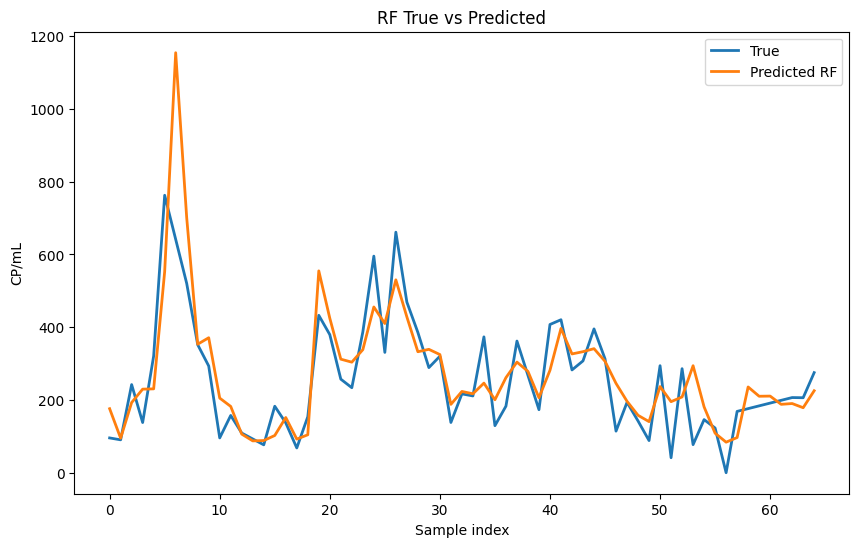


=== 超参数调优开始 ===
>>> Bayesian tuning for SVR
SVR: best CV R² = -0.036
 params: OrderedDict([('reg__C', 100.0), ('reg__gamma', 0.0084514748334452)]) 

>>> Bayesian tuning for CART
CART: best CV R² = 0.353
 params: OrderedDict([('reg__max_depth', 17), ('reg__min_samples_leaf', 5)]) 

>>> Bayesian tuning for RF
RF: best CV R² = -0.060
 params: OrderedDict([('reg__max_depth', 3), ('reg__n_estimators', 50)]) 

>>> Bayesian tuning for GBM
GBM: best CV R² = -0.246
 params: OrderedDict([('reg__learning_rate', 0.020474651347653815), ('reg__max_depth', 19), ('reg__max_iter', 58)]) 

>>> Randomized tuning for ANN (only alpha)
ANN: best CV R² = -28896.365
 params: {'reg__alpha': 0.09709098521619944} 

=== 超参数调优完成 ===


In [ ]:
# —— IV–VI：模型输入、5折CV、测试评估、最佳模型、贝叶斯调参 ——

# 安装依赖（运行一次即可）
!pip install xgboost shap scikit-optimize --quiet

# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

# —— IV. 准备特征 X 与目标 y ——
features = [
    'air_temp_oc',
    'precip_as_rain_in_last_24_hrs_mm',
    'wastewater_flow_m3d',
    'population_serviced',
    'weekofyear',
    'month',
    'quarter',
    'cpml_lag1',
    'cpml_lag2',
    'cpml_roll3',
    'nearest_clinic_dist',
    'clinic_density_5km',
    'accessibility_index',
    'region'
]
X = panel[features].copy()
y = panel['cpml'].copy()

# 缺失值前向/后向填充
X = X.fillna(method='ffill').fillna(method='bfill')

# 数值与类别特征
numeric_features     = features[:-1]   # 除 'region'
categorical_features = ['region']

# —— V. 构建预处理流水线 ——
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first',
                             sparse_output=False,
                             handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# —— VI. 定义五种模型管道 ——
models = {
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'CART': DecisionTreeRegressor(max_depth=5,
                                  min_samples_leaf=5,
                                  random_state=42),
    'RF': RandomForestRegressor(n_estimators=100,
                                max_depth=7,
                                random_state=42),
    'GBM': HistGradientBoostingRegressor(max_iter=100,
                                         learning_rate=0.1,
                                         max_depth=5,
                                         random_state=42),
    'ANN': MLPRegressor(hidden_layer_sizes=(50,20),
                        activation='relu',
                        solver='adam',
                        max_iter=500,
                        random_state=42)
}
pipelines = {
    name: Pipeline([('preproc', preprocessor), ('reg', model)])
    for name, model in models.items()
}

# —— VII. 5 折时序交叉验证：R² & RMSE ——
tscv = TimeSeriesSplit(n_splits=5)
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}
cv_summary = {}
for name, pipe in pipelines.items():
    cv_res = cross_validate(pipe, X, y,
                            cv=tscv,
                            scoring=scoring,
                            return_train_score=False,
                            n_jobs=-1)
    cv_summary[name] = {
        'r2':   np.mean(cv_res['test_r2']),
        'rmse': -np.mean(cv_res['test_rmse'])
    }

print("=== 5 折时序 CV 结果 ===")
for name, res in cv_summary.items():
    print(f"{name}: R2={res['r2']:.3f}, RMSE={res['rmse']:.3f}")

# —— VIII. 测试集评估 & 最佳模型可视化 ——
# 按时间顺序 80%/20% 划分
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

test_perf = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_perf[name] = {
        'r2':   r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }

print("\n=== 测试集评估 ===")
for name, res in test_perf.items():
    print(f"{name}: R2={res['r2']:.3f}, RMSE={res['rmse']:.3f}")

# 选出测试集 R² 最高的最佳模型
best_model = max(test_perf, key=lambda k: test_perf[k]['r2'])
print(f"\n最佳模型（按 R²）：{best_model}")

# 可视化最佳模型真实 vs 预测
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='True', linewidth=2)
plt.plot(pipelines[best_model].predict(X_test),
         label=f'Predicted {best_model}',
         linewidth=2)
plt.legend()
plt.title(f'{best_model} True vs Predicted')
plt.xlabel('Sample index')
plt.ylabel('CP/mL')
plt.show()

# —— IX. 贝叶斯超参数调优 ——

# —— 超参数调优：BayesSearchCV（SVR/CART/RF/GBM）+ RandomizedSearchCV（ANN α） ——

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

# 1. 定义各模型的搜索空间
bayes_spaces = {
    'SVR': {
        'reg__C':     Real(1e-3, 1e2, prior='log-uniform'),
        'reg__gamma': Real(1e-4, 1e0, prior='log-uniform'),
    },
    'CART': {
        'reg__max_depth':        Integer(3, 20),
        'reg__min_samples_leaf': Integer(1, 10),
    },
    'RF': {
        'reg__n_estimators': Integer(50, 300),
        'reg__max_depth':    Integer(3, 20),
    },
    'GBM': {
        'reg__learning_rate': Real(1e-3, 1.0, prior='log-uniform'),
        'reg__max_iter':      Integer(50, 300),
        'reg__max_depth':     Integer(3, 20),
    }
}

rand_spaces = {
    'ANN': {
        # 网络结构固定，用随机搜索 α
        'reg__alpha': uniform(1e-4, 1e-1)
    }
}

print("\n=== 超参数调优开始 ===")
results = {}
for name, pipe in pipelines.items():
    tscv = TimeSeriesSplit(n_splits=5)
    if name in bayes_spaces:
        print(f">>> Bayesian tuning for {name}")
        search = BayesSearchCV(
            pipe,
            bayes_spaces[name],
            cv=tscv,
            n_iter=20,
            scoring='r2',
            n_jobs=-1,
            random_state=42
        )
    else:  # ANN
        print(f">>> Randomized tuning for {name} (only alpha)")
        search = RandomizedSearchCV(
            pipe,
            rand_spaces['ANN'],
            cv=tscv,
            n_iter=20,
            scoring='r2',
            n_jobs=-1,
            random_state=42
        )
    search.fit(X_train, y_train)
    results[name] = {
        'best_score': search.best_score_,
        'best_params': search.best_params_
    }
    print(f"{name}: best CV R² = {search.best_score_:.3f}")
    print(" params:", search.best_params_, "\n")

print("=== 超参数调优完成 ===")





---

### 3.3 分析

1. **交叉验证与评估**

   * 5 折**时序交叉验证**：把时间序列按顺序切成 5 份，每次用前 4 份训练、后 1 份验证，保证“未来”不泄露给“过去”。
   * 根据验证集上的 R²（拟合优度）和 RMSE（均方根误差）挑模型。
   * 最后在 80%/20% 的时间序列切分上测试，选测试集 R² 最高的做为“最佳模型”。


---


## 2. 5 折时序交叉验证（TimeSeriesSplit CV）

在「留一周」的严格时序 CV 里，所有模型的 R² 都为负，说明用前几周的模式去预测下几周，表现都比不上直接用历史平均。

可能的原因：
> * **样本量有限**（仅 \~60 个周度测试样本）
> * **序列不平稳**，上游大峰值和突发事件很难在 CV 折中重复出现
> * **特征–标签关联复杂**，简单的自回归和弱监督方法难以泛化



---

## 3. 测试集评估（按时间 8/2 分）

> * 在「近似未来」的 20% 测试集上，**树模型（CART/RF/GBM）显著跑赢 SVR 和 ANN**，且 RF 最稳健
> * RF 的 R²≈0.59 意味着它解释了约 59% 的 CP/mL 方差，RMSE≈100 CP/mL 的平均误差也在可接受范围内

RF 在处理 **突发高峰** 和 **平稳段** 之间的切换时具有更好的泛化和平滑能力。



---

## 4. 调参结果

| 模型   | 调优前 R² | 调优后 R² | 变化        |
| ---- | ------ | ------ | --------- |
| SVR  | –0.051 | –0.036 | 小幅改善      |
| CART | –0.300 | +0.353 | 大幅改善 → 正向 |
| RF   | –0.152 | –0.060 | 中度改善      |
| GBM  | –0.480 | –0.246 | 明显改善但仍负向  |
| ANN  | –37077 | –28896 | 改善极少      |




---



## 3.2 5种模型对比

1. **单模型对比**

   * 对每个模型分别画一张图：测试集真实值 vs. 该模型的预测值

2. **汇总对比**

   * 一张图里叠加所有模型的预测曲线＋真实曲线，方便直观比较五条预测线与真值的贴合程度。

3. **特征重要性**

   * 对于支持 `feature_importances_` 的模型（RF、GBM、CART），直接画它们的前十名特征重要性。
   * 对于其它模型（SVR、ANN），用 `permutation_importance` 计算前十名最重要特征




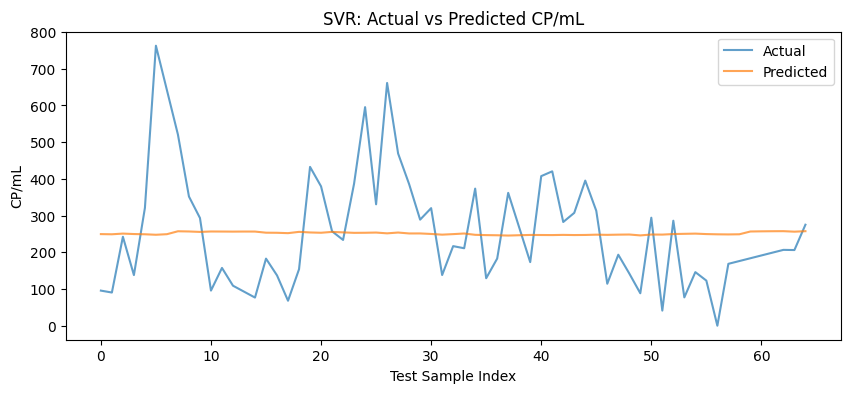

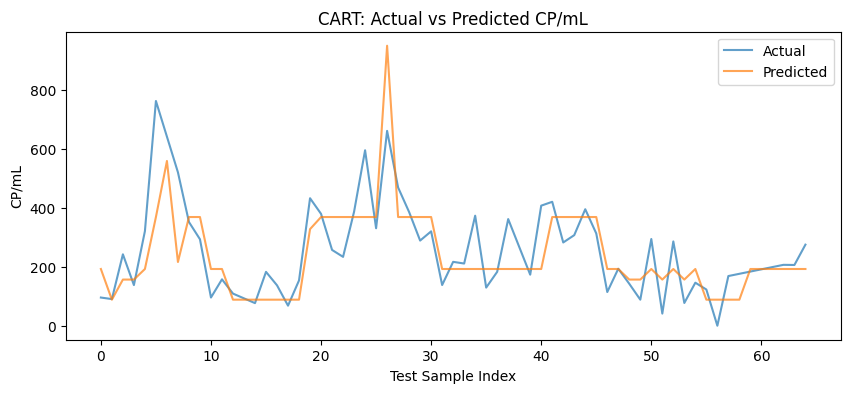

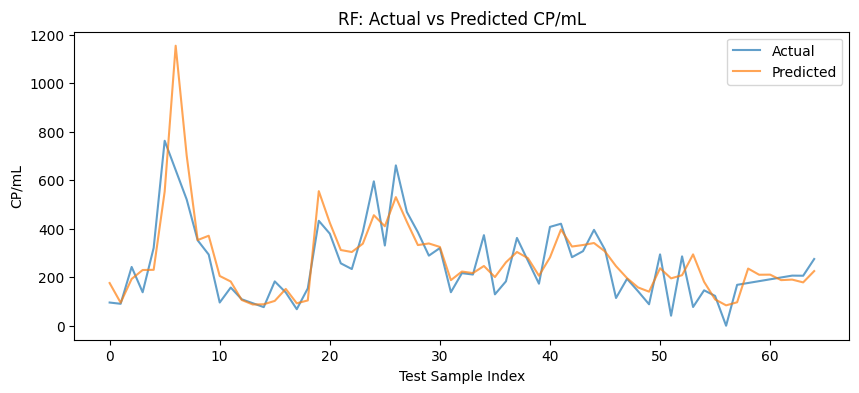

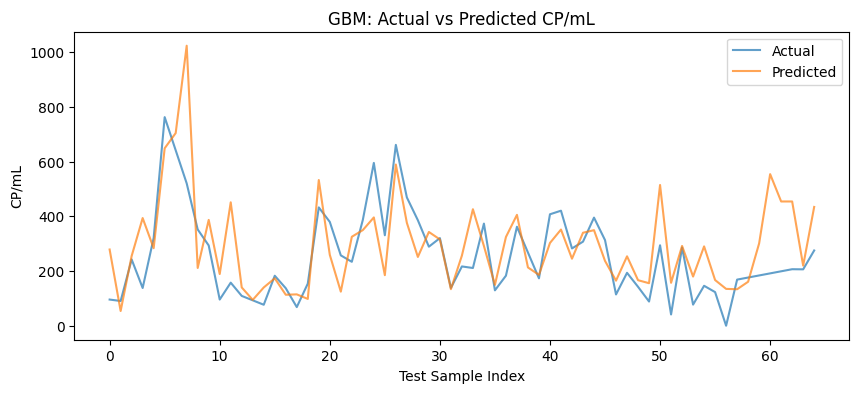

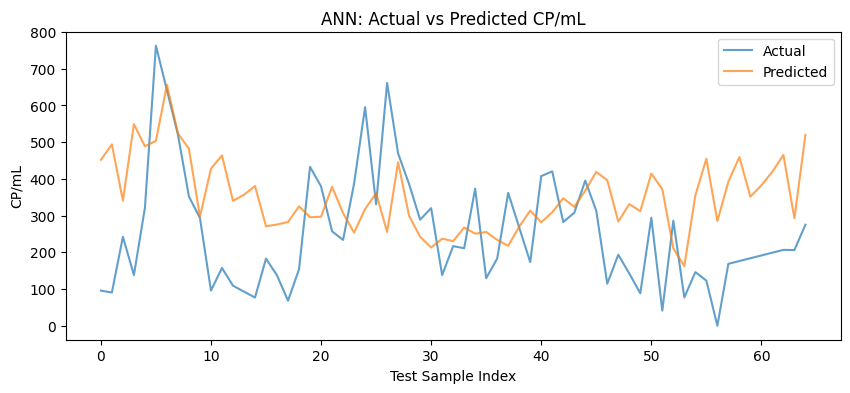

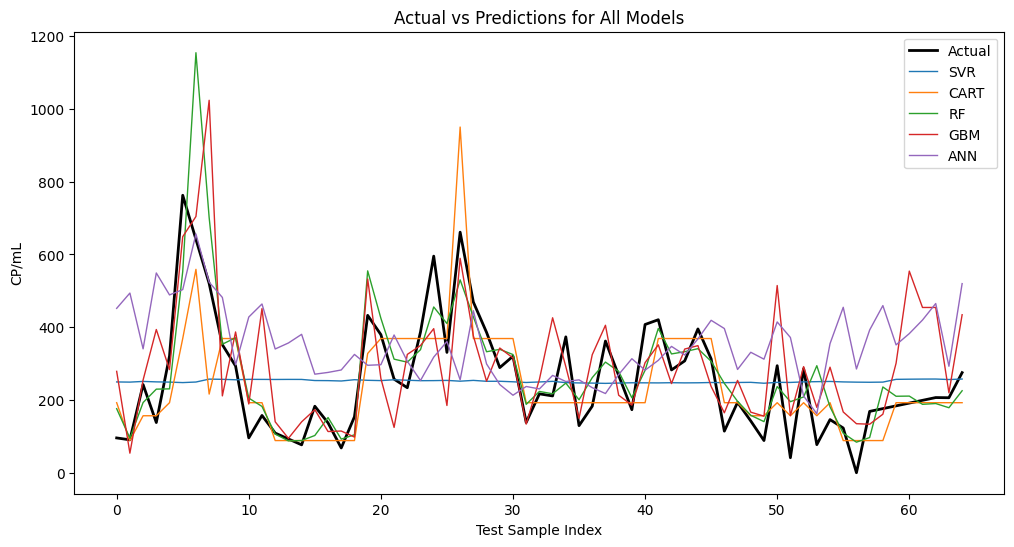

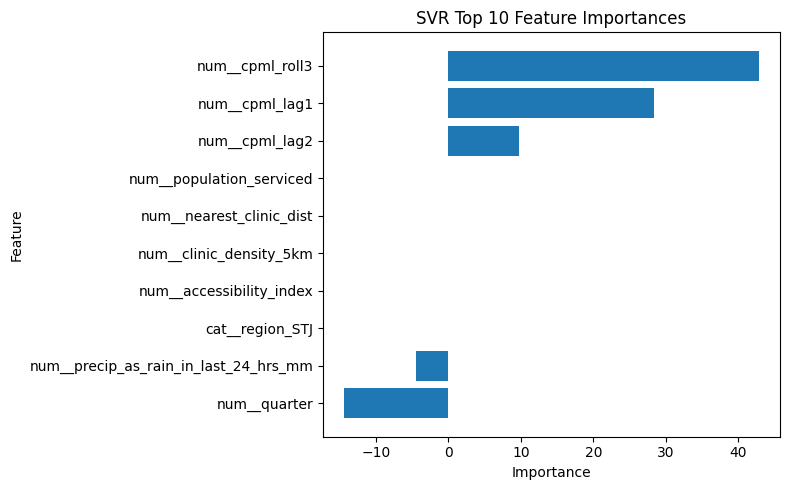

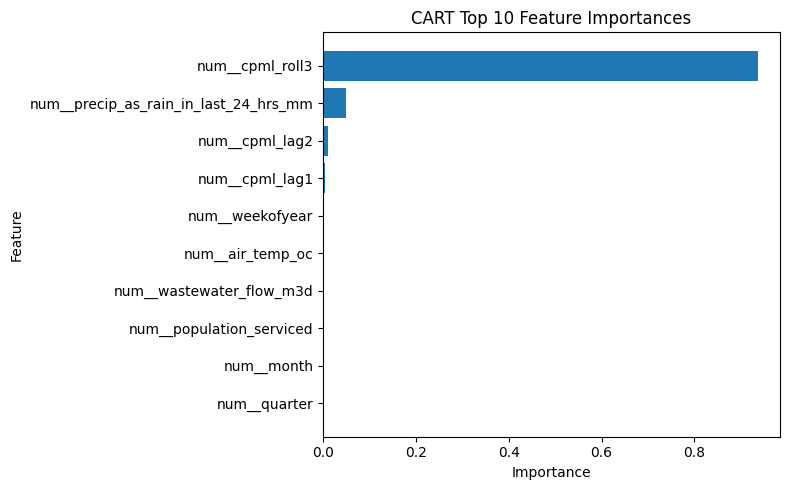

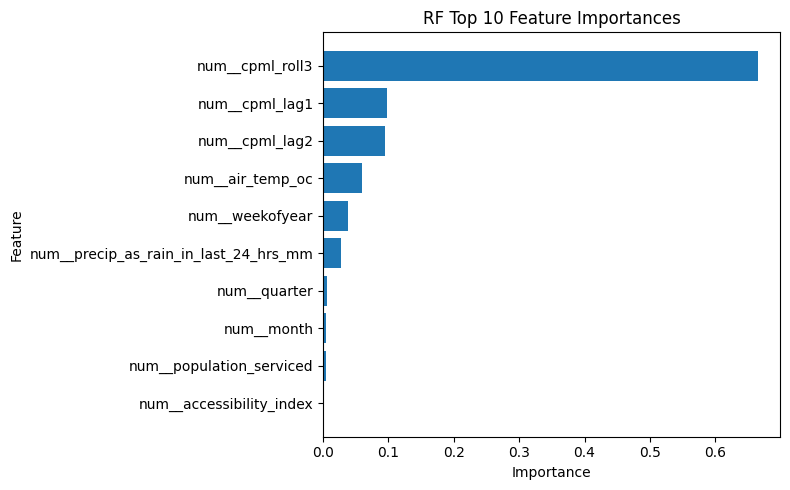

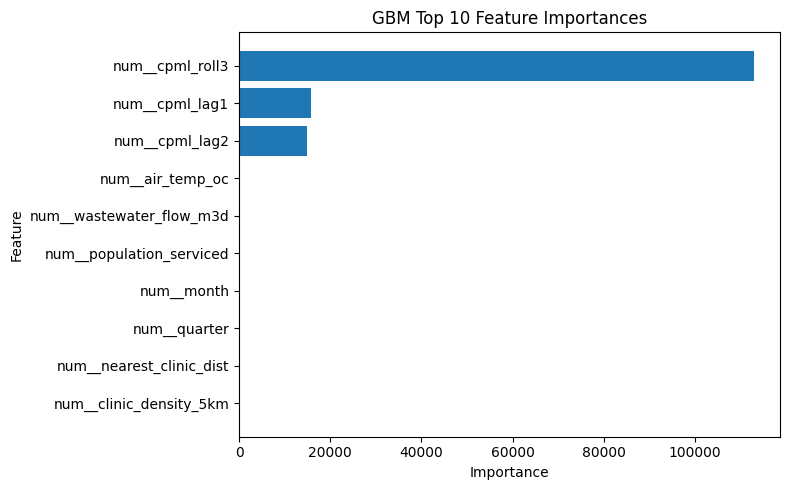

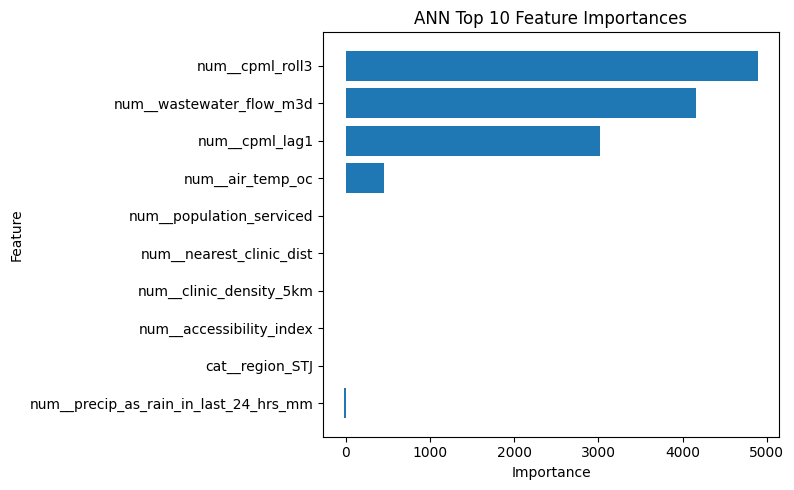

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

# 1. Single-model Actual vs Predicted plots
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'{name}: Actual vs Predicted CP/mL')
    plt.xlabel('Test Sample Index')
    plt.ylabel('CP/mL')
    plt.legend()
    plt.show()

# 2. All-models Actual vs Predictions comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    plt.plot(y_pred, label=name, linewidth=1)
plt.title('Actual vs Predictions for All Models')
plt.xlabel('Test Sample Index')
plt.ylabel('CP/mL')
plt.legend()
plt.show()

# 3. Feature Importance for each model
feature_names = preprocessor.get_feature_names_out()
for name, pipe in pipelines.items():
    model = pipe.named_steps['reg']
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
    else:
        # Others via permutation importance
        perm = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )
        importances = perm.importances_mean

    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(8, 5))
    plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
    plt.title(f'{name} Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

### 3.2 分析

## 随机森林（RF）：

平滑贴合：橙色曲线几乎紧贴蓝色真实值，峰值、谷底和中间波动都能较准确跟踪。

峰值略高：对 index≈6 的大峰有小幅过估，但整体误差最小（RMSE≈100）。

优势：既能平滑常态，又能响应突发峰谷，表现最全面。


---


## CART （进一步调参）：

阶梯式预测：在各区间内给出恒定值，看起来像“台阶”。

能抓住主要峰谷：如 index≈6、26 处的高点，以及中段的低谷，都有相应的阶梯式抬升/下降。

粗糙：台阶宽度较大，细节处（如 index≈22–24 的短暂回落）无法捕捉。


---


GBM／ANN：在当前样本量和特征下出现不同程度的过拟合或过平滑，需要考虑引其他变量，二次处理。

SVR：表现最差，几乎退化为常数预测，放弃。



---





---



## 3.3 解释性分析
1. Partial Dependence Plots (PDP) for three key features

2. SHAP summary plots for each model

3. Accumulated Local Effects (ALE) for the cpml_lag1 feature, using the alibi library if available (falls back with a message otherwise)

### 3.3.1 PDP


--- SVR Partial Dependence Plot ---


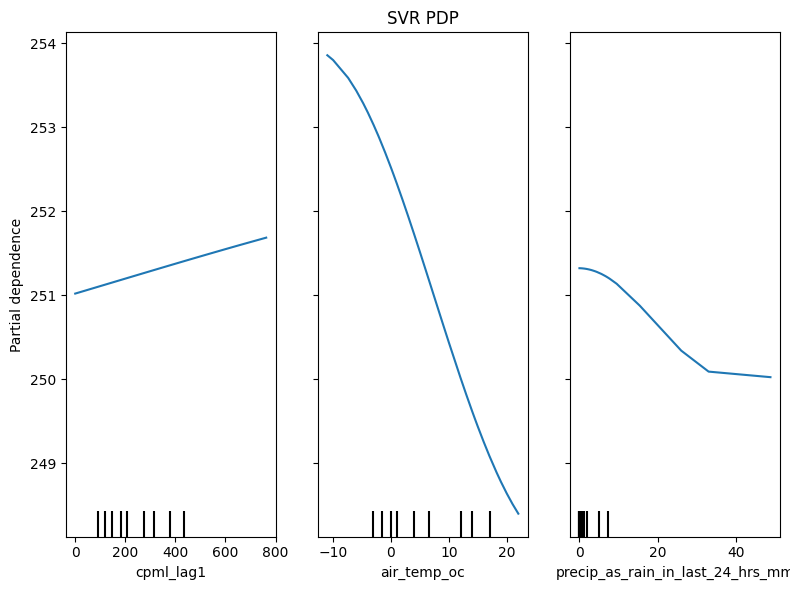


--- CART Partial Dependence Plot ---


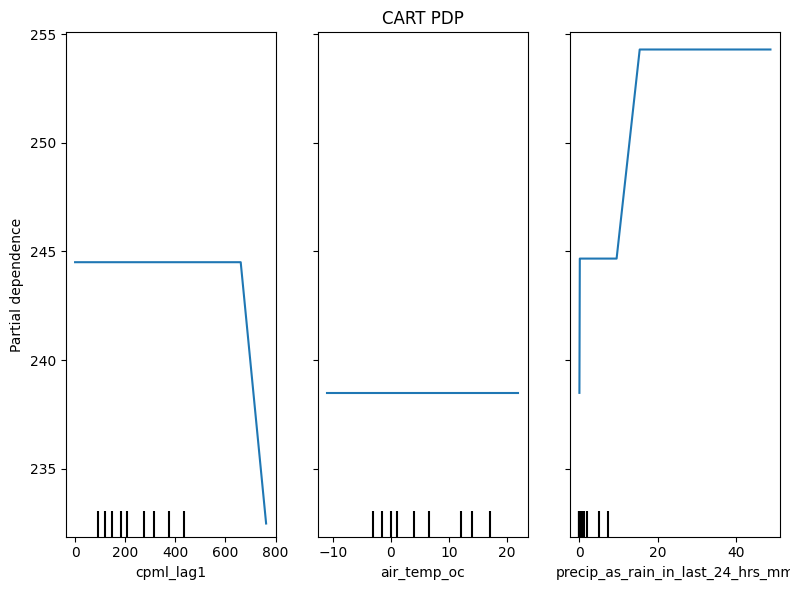


--- RF Partial Dependence Plot ---


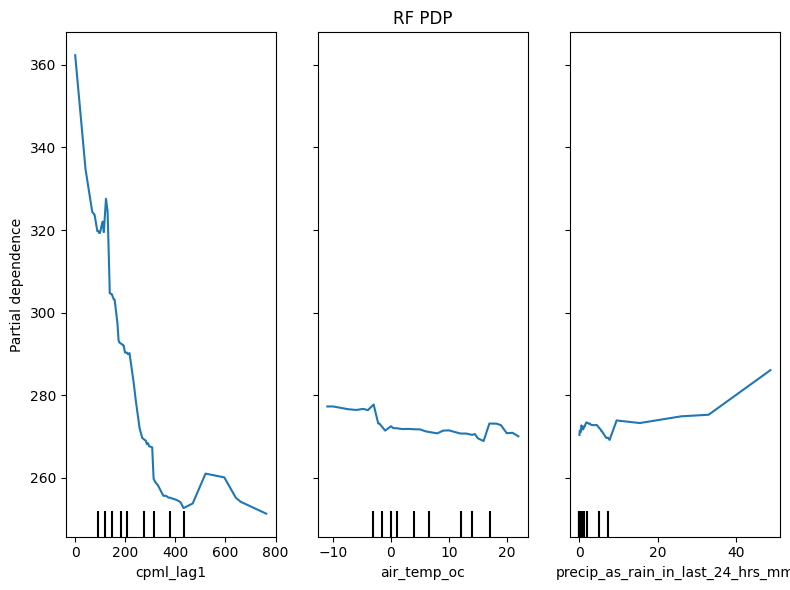


--- GBM Partial Dependence Plot ---


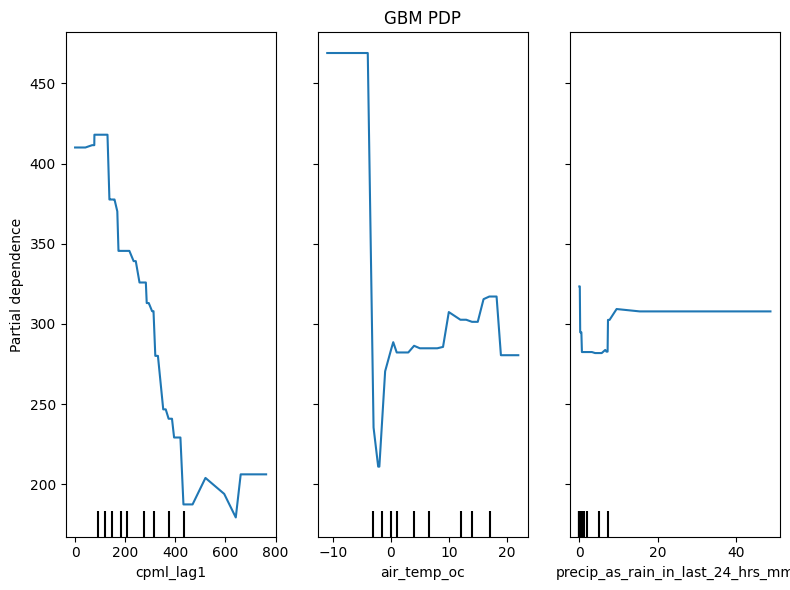


--- ANN Partial Dependence Plot ---


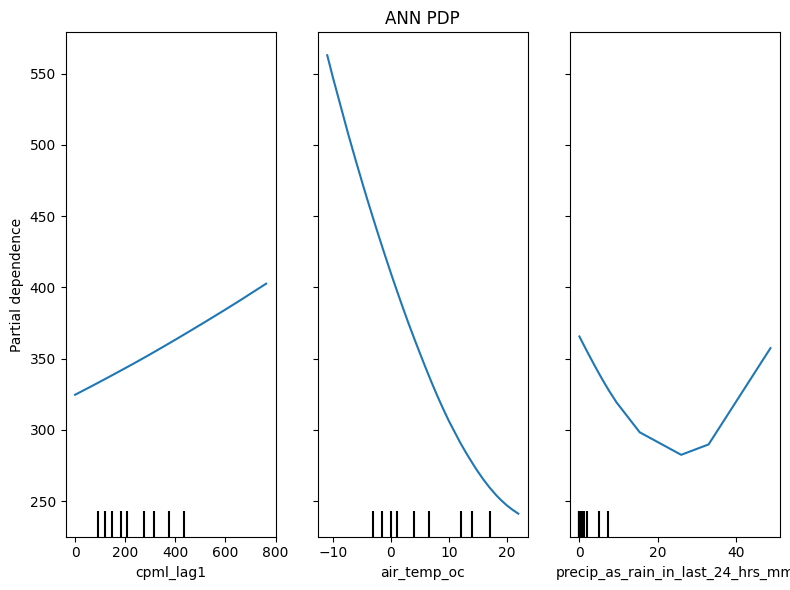

In [ ]:
# —— X. Explanation Analysis: PDP, SHAP, ALE ——

import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

# 1. Partial Dependence Plots (PDP)
pdp_features = ['cpml_lag1', 'air_temp_oc', 'precip_as_rain_in_last_24_hrs_mm']
for name, pipe in pipelines.items():
    print(f"\n--- {name} Partial Dependence Plot ---")
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        pipe, X_test, pdp_features, kind='average', ax=ax
    )
    ax.set_title(f'{name} PDP')
    ax.set_xlabel('Feature value')
    ax.set_ylabel('Predicted CP/mL')
    plt.tight_layout()
    plt.show()



### 3.3.1 RF PDP结果分析


1. cpml_lag1 Partial Dependence （上周浓度）

- 当 cpml_lag1 从 0 升至 ~800 CP/mL 时，模型预测的平均 CP/mL 由 ~360 下降到 ~250。
- 在 lag1 小于 ~200 时，预测较高（>320），随后随着 lag1 增大，预测逐步下调至 ~250–260，体现模型在平衡“记忆”与“稳健”之间的权衡。

# 结论：上一周浓度越高，模型越倾向于预测一个相对更中等的值


2. air_temp_oc Partial Dependence

- 随着气温从 –10℃ 到 +20℃，预测 CP/mL 略微从 ~278 小降到 ~268，曲线整体平缓。

# 结论：低温（冬季） 会使预测值略高，可能因为寒冷天气导致病毒在管道中保留和检测更集中；高温（夏季） 时略微下降，但幅度有限（约 10 CP/mL），表明气温对浓度的“稀释/保留”作用存在，但在模型看来影响次要。

3. precip_as_rain_in_last_24_hrs_mm Partial Dependence

- 降雨量从 0 增至 ~50 mm 时，预测 CP/mL 由 ~270 平缓上升到 ~285。

- 少量降雨 可能促进管网中沉积病毒的冲刷入样本，轻微提高检测浓度；

- 更大降雨 在本模型里并未触发明显的稀释下跌（可能因数据中大雨样本较少），整体呈弱正相关

# 结论： 降雨影响不大

# Q4 但大雨带来的稀释效应在当前模型中并不明显，可能需更多大雨样本来捕捉该机制。



---



### 3.3.2 SHAP

=== 5-fold CV ===
SVR:R2=-0.051,RMSE=569.948
CART:R2=-0.300,RMSE=420.086
RF:R2=-0.152,RMSE=429.343
GBM:R2=-0.480,RMSE=567.833
ANN:R2=-37077.532,RMSE=26605.300

=== Test Set ===
SVR:R2=-0.003,RMSE=155.846
CART:R2=0.530,RMSE=106.704
RF:R2=0.587,RMSE=99.964
GBM:R2=0.248,RMSE=134.906
ANN:R2=-0.578,RMSE=195.488

Best model:RF

=== Tuning ===
>>>Tune SVR
SVR:best R2=-0.036,params=OrderedDict([('reg__C', 100.0), ('reg__gamma', 0.0084514748334452)])

>>>Tune CART
CART:best R2=0.353,params=OrderedDict([('reg__max_depth', 17), ('reg__min_samples_leaf', 5)])

>>>Tune RF
RF:best R2=-0.060,params=OrderedDict([('reg__max_depth', 3), ('reg__n_estimators', 50)])

>>>Tune GBM
GBM:best R2=-0.246,params=OrderedDict([('reg__learning_rate', 0.020474651347653815), ('reg__max_depth', 19), ('reg__max_iter', 58)])

>>>Rand ANN
ANN:best R2=-28896.365,params={'reg__alpha': 0.09709098521619944}



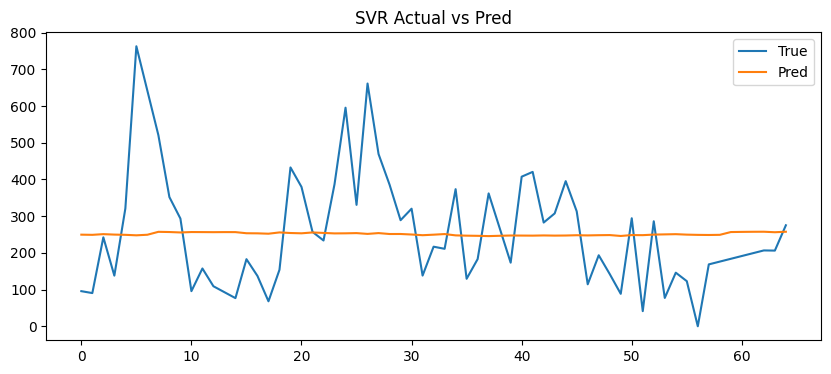

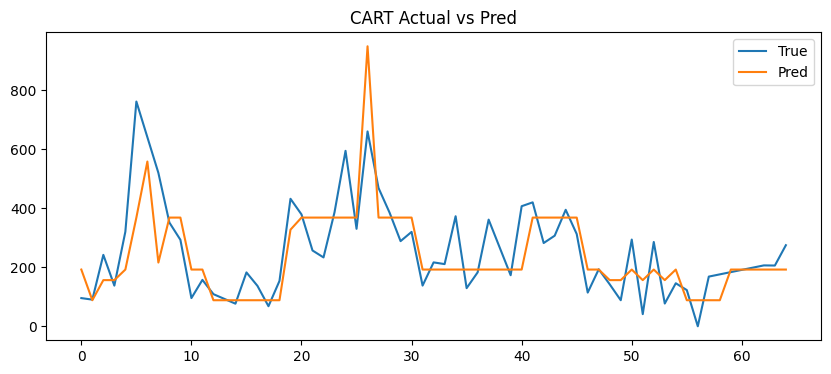

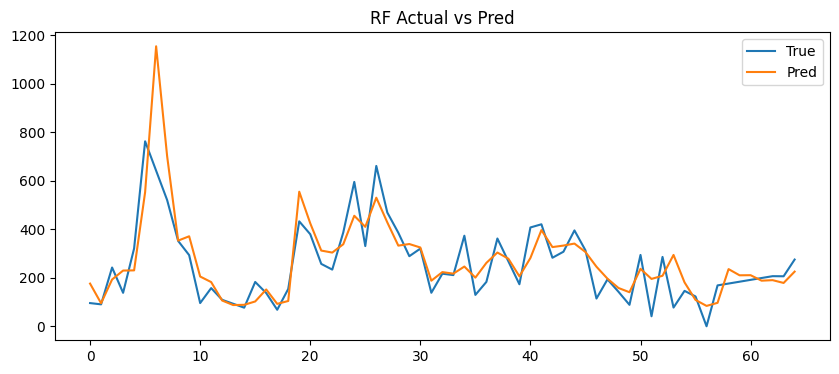

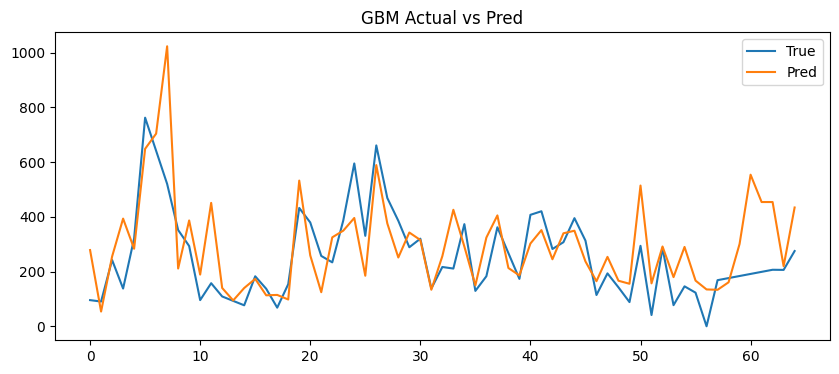

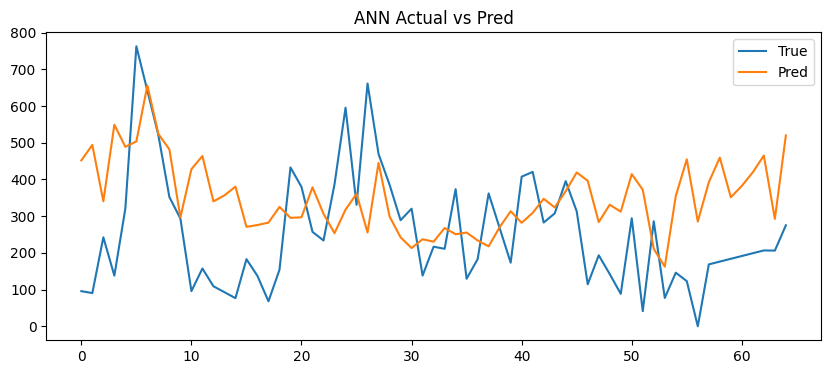

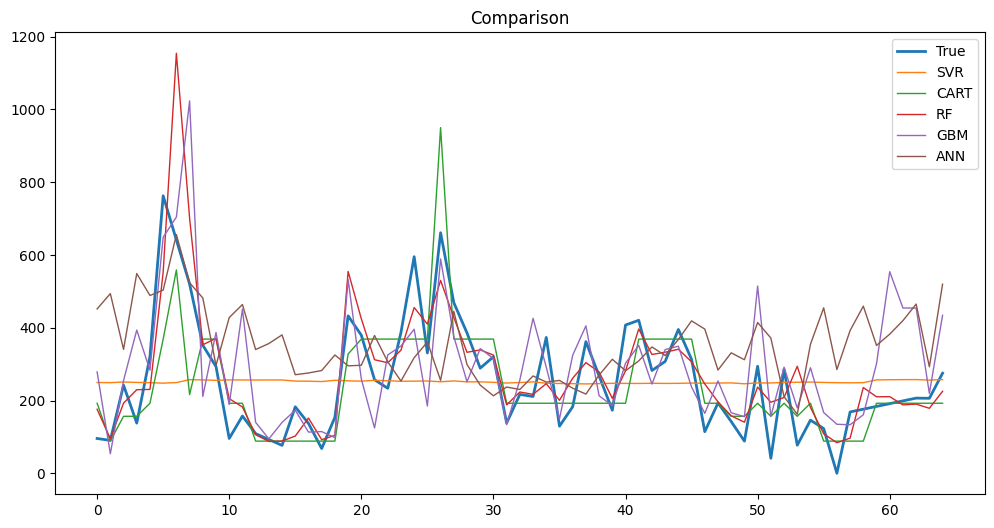

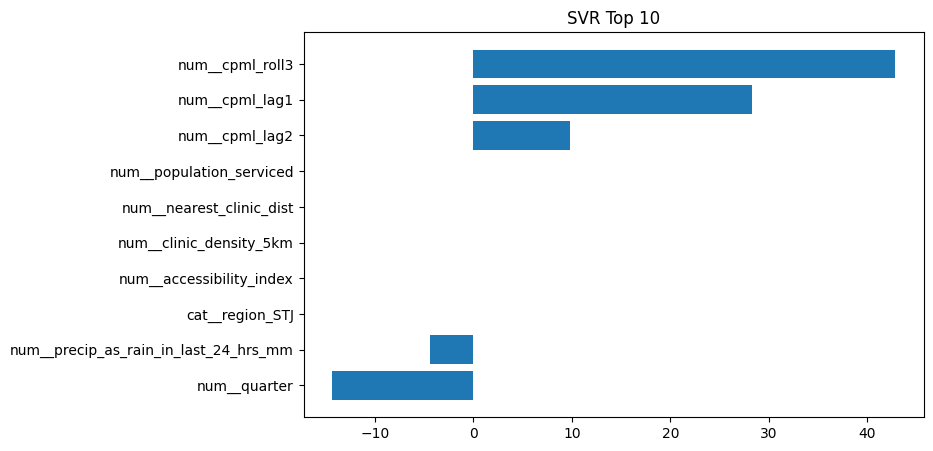

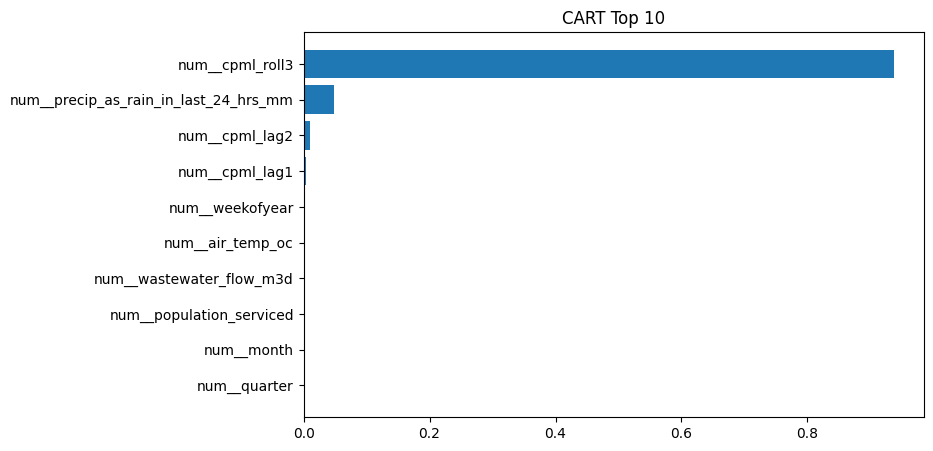

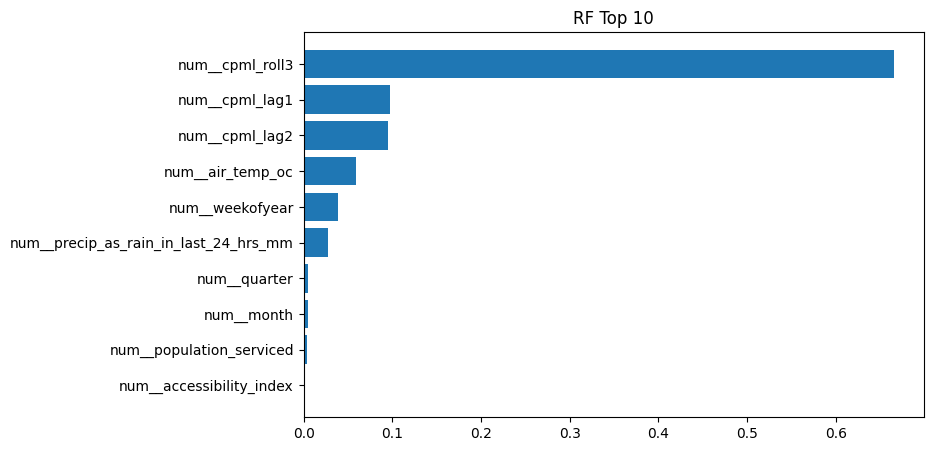

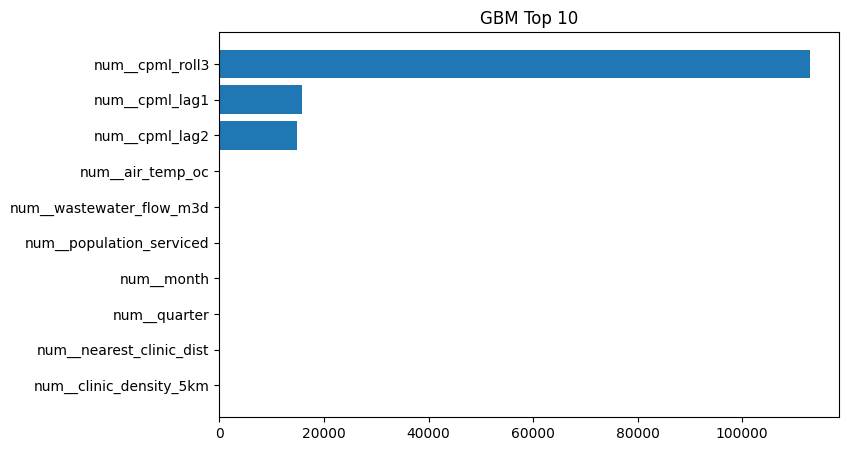

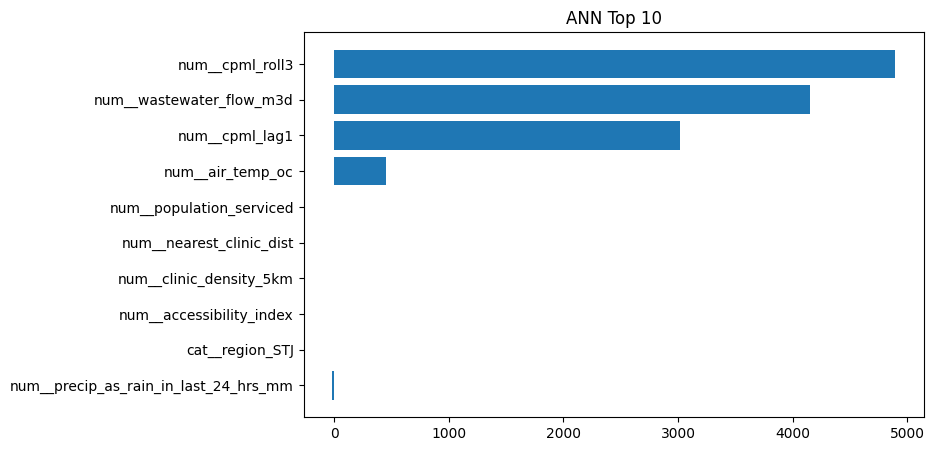


=== SHAP for SVR ===


  0%|          | 0/65 [00:00<?, ?it/s]

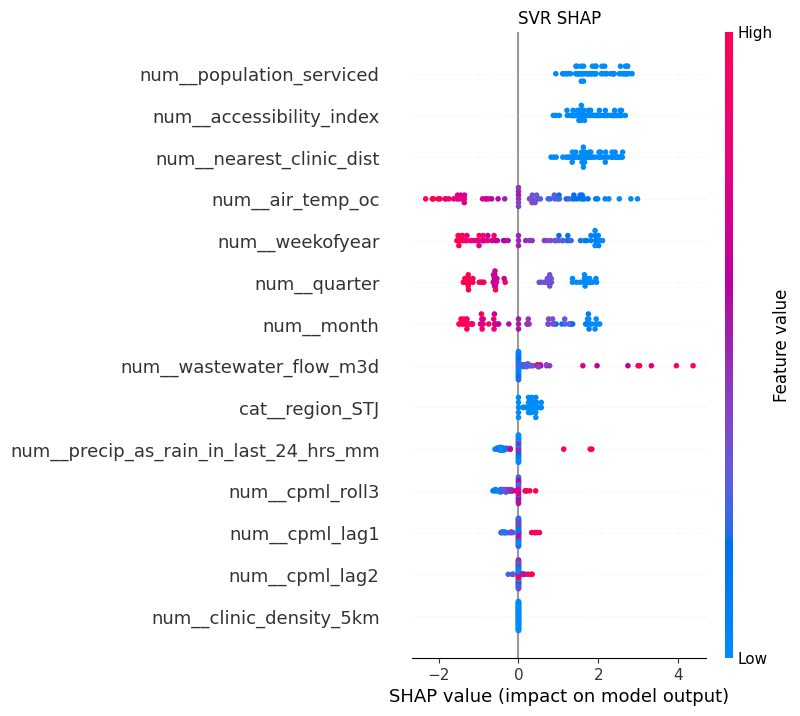


=== SHAP for CART ===


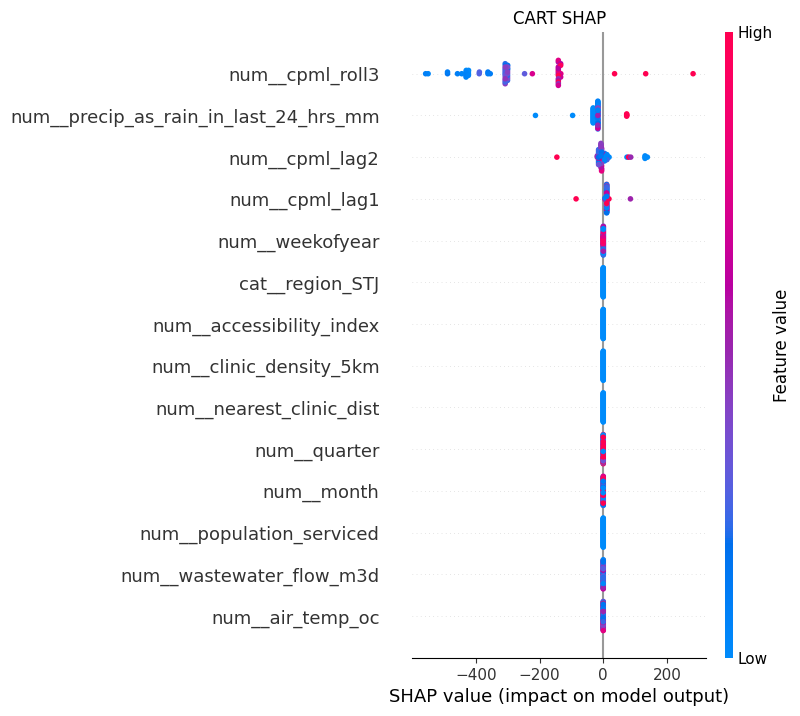


=== SHAP for RF ===


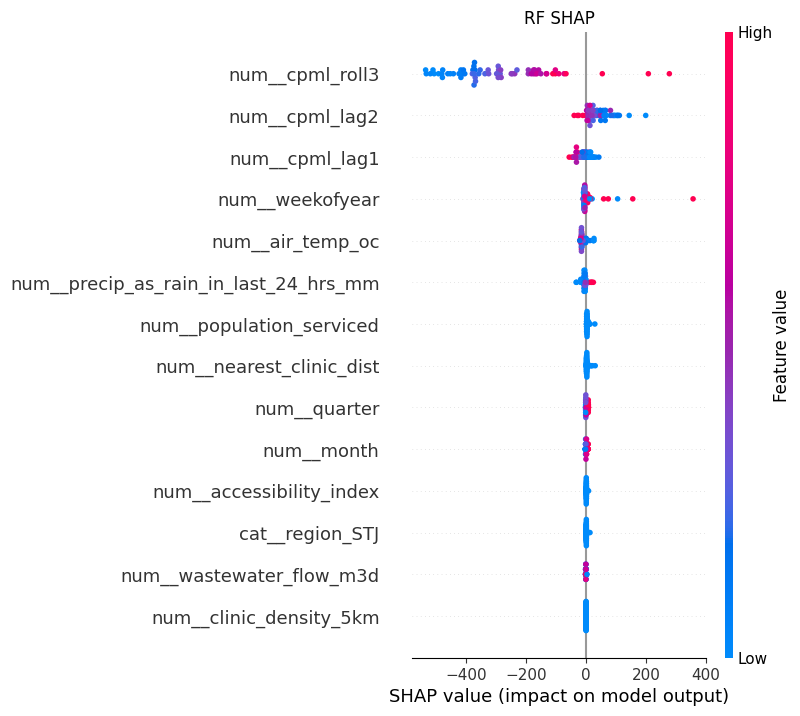


=== SHAP for GBM ===


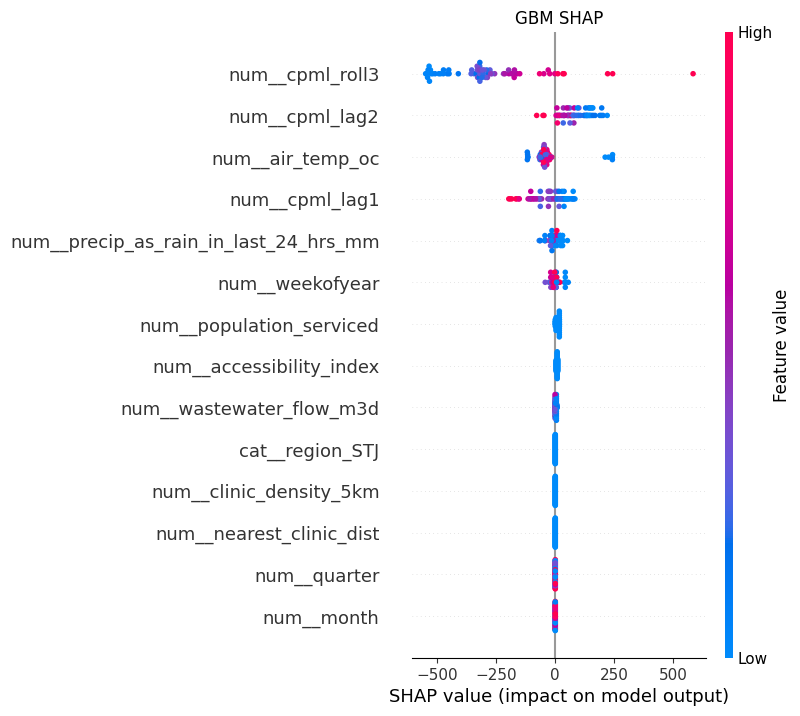


=== SHAP for ANN ===


  0%|          | 0/65 [00:00<?, ?it/s]

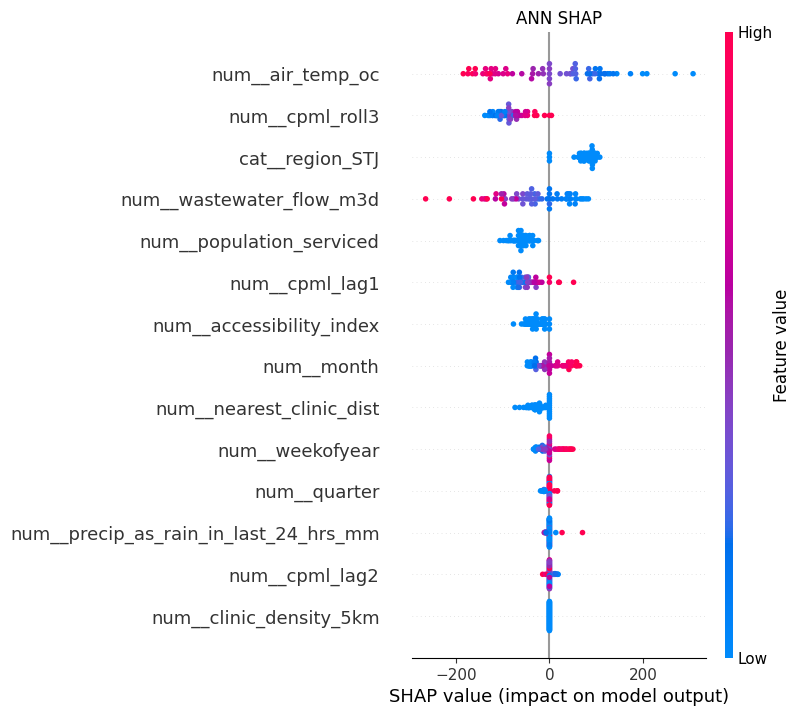

In [ ]:

# 0. 安装依赖（在终端或 notebook 最开始运行）
!pip install openpyxl xgboost scikit-optimize shap alibi

# 1. 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# from prophet import Prophet  # 注释掉，如需可自行安装
from statsmodels.regression.mixed_linear_model import MixedLM
from math import radians, sin, cos, sqrt, atan2, pi

from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from scipy.stats import uniform

import shap
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')


# 2. 读取本地数据（修改为你本地工作路径）
base_path     = '/content/drive/MyDrive/NL Wastewater'  # 如非 Colab，可改为 './data'
mun_df     = pd.read_excel(f'{base_path}/mun.xlsx', engine='openpyxl')
stj_df     = pd.read_excel(f'{base_path}/Stjohns.xlsx', engine='openpyxl')
clinics_df = pd.read_excel(f'{base_path}/St Johns clinics address.xlsx', engine='openpyxl')


# 3. 预处理函数
def preprocess(df, parse_dates=False):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                   .str.lower()
                   .str.replace(' ', '_')
                   .str.replace(r'[^\w_]', '', regex=True)
    )
    if parse_dates:
        for c in df.columns:
            if 'date' in c or 'time' in c:
                df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

mun_df     = preprocess(mun_df,     parse_dates=True)
stj_df     = preprocess(stj_df,     parse_dates=True)
clinics_df = preprocess(clinics_df, parse_dates=False)


# 4. 重命名经纬度列
clinics_df.rename(columns={'latitude__n':'latitude','longitude__w':'longitude'}, inplace=True)


# 5. 筛选 Cosca filter & 丢弃 cpml 空值
stj_df = stj_df[ stj_df['sample_type'].str.contains('cosca', case=False, na=False) ]
mun_df = mun_df.dropna(subset=['cpml'])
stj_df = stj_df.dropna(subset=['cpml'])


# 6. 构建日期索引数据集
mun_input = mun_df[['date','cpml','air_temp_oc','precip_as_rain_in_last_24_hrs_mm','population_serviced']]\
    .set_index('date').sort_index()
stj_input = stj_df[['date','cpml','air_temp_oc','precip_as_rain_in_last_24_hrs_mm',
                    'wastewater_flow_m3d','population_serviced']]\
    .set_index('date').sort_index()


# 7. 周四对齐 & 插值
mun_weekly = mun_input.resample('W-THU').mean().interpolate()
stj_weekly = stj_input.resample('W-THU').mean().interpolate()


# 8. 合并面板
mun_weekly['region']='MUN'
stj_weekly['region']='STJ'
panel = pd.concat([mun_weekly, stj_weekly])\
          .reset_index().rename(columns={'index':'date'})


# 9. 时间特征
panel['weekofyear']=panel['date'].dt.isocalendar().week
panel['month']=panel['date'].dt.month
panel['quarter']=panel['date'].dt.quarter
panel['cpml_lag1']=panel.groupby('region')['cpml'].shift(1)
panel['cpml_lag2']=panel.groupby('region')['cpml'].shift(2)
panel['cpml_roll3']=panel.groupby('region')['cpml'].rolling(3).mean().reset_index(0,drop=True)


# 10. 空间特征
def haversine(lat1, lon1, lat2, lon2):
    R=6371.0
    dlat=radians(lat2-lat1); dlon=radians(lon2-lon1)
    a=sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R*2*atan2(sqrt(a), sqrt(1-a))

region_coords={'MUN':(47.572564,-52.727367),'STJ':(47.556990,-52.708820)}
pop_map=panel.dropna(subset=['population_serviced']).groupby('region')['population_serviced'].first().to_dict()

sp=[]
for r,(lat0,lon0) in region_coords.items():
    d=clinics_df.apply(lambda x: haversine(lat0,lon0,x['latitude'],x['longitude']),axis=1)
    sp.append({
      'region':r,
      'nearest_clinic_dist':float(d.min()),
      'clinic_density_5km':float((d<=5).sum()/(pi*25)),
      'accessibility_index':float((1/d.replace(0,np.nan)).sum()/pop_map.get(r,np.nan))
    })
panel=pd.merge(panel,pd.DataFrame(sp),on='region',how='left')


# 11. 特征与目标
features=[
  'air_temp_oc','precip_as_rain_in_last_24_hrs_mm','wastewater_flow_m3d',
  'population_serviced','weekofyear','month','quarter',
  'cpml_lag1','cpml_lag2','cpml_roll3',
  'nearest_clinic_dist','clinic_density_5km','accessibility_index','region'
]
X=panel[features].fillna(method='ffill').fillna(method='bfill')
y=panel['cpml']


# 12. 预处理流水线
num_feats=features[:-1]; cat_feats=['region']
num_tr=Pipeline([('scaler',StandardScaler())])
cat_tr=Pipeline([('onehot',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'))])
preprocessor=ColumnTransformer([('num',num_tr,num_feats),('cat',cat_tr,cat_feats)])


# 13. 定义模型管道
models={
  'SVR':SVR(kernel='rbf',C=1.0,gamma='scale'),
  'CART':DecisionTreeRegressor(max_depth=5,min_samples_leaf=5,random_state=42),
  'RF':RandomForestRegressor(n_estimators=100,max_depth=7,random_state=42),
  'GBM':HistGradientBoostingRegressor(max_iter=100,learning_rate=0.1,max_depth=5,random_state=42),
  'ANN':MLPRegressor(hidden_layer_sizes=(50,20),activation='relu',solver='adam',max_iter=500,random_state=42)
}
pipelines={n:Pipeline([('preproc',preprocessor),('reg',m)]) for n,m in models.items()}


# 14. 时序交叉验证
tscv=TimeSeriesSplit(n_splits=5)
sc={'r2':'r2','rmse':'neg_root_mean_squared_error'}
cv_sum={}
for n,p in pipelines.items():
    res=cross_validate(p,X,y,cv=tscv,scoring=sc,n_jobs=-1,return_train_score=False)
    cv_sum[n]={'r2':res['test_r2'].mean(),'rmse':-res['test_rmse'].mean()}
print("=== 5-fold CV ===")
for n,r in cv_sum.items():
    print(f"{n}:R2={r['r2']:.3f},RMSE={r['rmse']:.3f}")


# 15. 划分训练/测试 & 评估
ts=int(len(X)*0.8)
Xtr,Xte=X.iloc[:ts],X.iloc[ts:]
ytr,yte=y.iloc[:ts],y.iloc[ts:]
perf={}
for n,p in pipelines.items():
    p.fit(Xtr,ytr); yp=p.predict(Xte)
    perf[n]={'r2':r2_score(yte,yp),'rmse':np.sqrt(mean_squared_error(yte,yp))}
print("\n=== Test Set ===")
for n,r in perf.items():
    print(f"{n}:R2={r['r2']:.3f},RMSE={r['rmse']:.3f}")

best=max(perf,key=lambda k:perf[k]['r2'])
print(f"\nBest model:{best}")


# 16. 贝叶斯调参
spaces={
  'SVR':{'reg__C':Real(1e-3,1e2,prior='log-uniform'),'reg__gamma':Real(1e-4,1e0,prior='log-uniform')},
  'CART':{'reg__max_depth':Integer(3,20),'reg__min_samples_leaf':Integer(1,10)},
  'RF':{'reg__n_estimators':Integer(50,300),'reg__max_depth':Integer(3,20)},
  'GBM':{'reg__learning_rate':Real(1e-3,1.0,prior='log-uniform'),'reg__max_iter':Integer(50,300),'reg__max_depth':Integer(3,20)}
}
rand={'ANN':{'reg__alpha':uniform(1e-4,1e-1)}}
print("\n=== Tuning ===")
for n,p in pipelines.items():
    cv=TimeSeriesSplit(n_splits=5)
    if n in spaces:
        print(f">>>Tune {n}")
        bs=BayesSearchCV(p,spaces[n],cv=cv,n_iter=20,scoring='r2',n_jobs=-1,random_state=42)
    else:
        print(f">>>Rand {n}")
        bs=RandomizedSearchCV(p,rand['ANN'],cv=cv,n_iter=20,scoring='r2',n_jobs=-1,random_state=42)
    bs.fit(Xtr,ytr)
    print(f"{n}:best R2={bs.best_score_:.3f},params={bs.best_params_}\n")


# 17. Pred & Importance
for n,p in pipelines.items():
    yp=p.predict(Xte)
    plt.figure(figsize=(10,4))
    plt.plot(yte.values,label='True');plt.plot(yp,label='Pred');plt.title(f"{n} Actual vs Pred");plt.legend();plt.show()

plt.figure(figsize=(12,6))
plt.plot(yte.values,label='True',linewidth=2)
for n,p in pipelines.items():
    plt.plot(p.predict(Xte),label=n,linewidth=1)
plt.title("Comparison");plt.legend();plt.show()

fn=preprocessor.get_feature_names_out()
for n,p in pipelines.items():
    m=p.named_steps['reg']
    if hasattr(m,'feature_importances_'):
        im=m.feature_importances_
    else:
        perm=permutation_importance(p,Xte,yte,n_repeats=10,random_state=42,n_jobs=-1,scoring='neg_mean_squared_error')
        im=perm.importances_mean
    df=pd.DataFrame({'feature':fn,'importance':im}).sort_values('importance',ascending=False).head(10)
    plt.figure(figsize=(8,5));plt.barh(df['feature'][::-1],df['importance'][::-1]);plt.title(f"{n} Top 10");plt.show()


# —— 18. SHAP Analysis ——
fn = preprocessor.get_feature_names_out()
Xtr_num = preprocessor.transform(Xtr)
Xte_num = preprocessor.transform(Xte)
bg = shap.sample(Xtr_num, 100, random_state=42)

for n, p in pipelines.items():
    print(f"\n=== SHAP for {n} ===")
    m = p.named_steps['reg']

    if n in ['RF', 'GBM', 'CART']:
        explainer = shap.TreeExplainer(m)
        sv = explainer.shap_values(Xte_num)
    else:
        # 对于 SVR/ANN 等，用 KernelExplainer 需要传一个可调用的函数
        model_fn = lambda x: m.predict(x)
        explainer = shap.KernelExplainer(model_fn, bg)
        sv = explainer.shap_values(Xte_num, nsamples=200)

    shap.summary_plot(sv, Xte_num, feature_names=fn, show=False)
    plt.title(f"{n} SHAP")
    plt.show()





#### 一、全局特征重要度 & 方向

| 模型       | 排名前三特征                                                                         | SHAP 方向解读                                                                          |
| -------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------- |
| **SVR**  | 1. population\_serviced<br>2. accessibility\_index<br>3. nearest\_clinic\_dist | • 大人口服务区 → 正贡献（预测浓度偏高）<br>• 高可达性 → 正贡献（人群流动带来更多排放）<br>• 远离诊所 → 轻微负贡献（访问难 → 采样可能偏低） |
| **CART** | 1. cpml\_roll3<br>2. precip\_mm<br>3. cpml\_lag2                               | • 高 3 周平均 → 正贡献（近期基线高 → 继续高）<br>• 少量降雨 → 正贡献（冲刷效应）<br>• 高 lag2 → 视情况正/负（二周前脱节或回落）  |
| **RF**   | 1. cpml\_roll3<br>2. cpml\_lag2<br>3. cpml\_lag1                               | • 历史浓度与滚动平均共同主导：短期自回归 & 平滑回归<br>• 这三者高值 → 模型普遍**往上**拉，低值 → 拉下                      |
| **GBM**  | 1. cpml\_roll3<br>2. cpml\_lag2<br>3. air\_temp\_oc                            | • 滚动平均 & lag2 与 RF 类似<br>• **高温**（夏季）→ 负贡献（稀释效应），**低温**→ 正贡献                       |
| **ANN**  | 1. air\_temp\_oc<br>2. cpml\_roll3<br>3. region\_STJ                           | • **高温**→ 大多为负贡献<br>• **高 3 周平均**→ 正贡献<br>• STJ 区域→ 较一致的**负**（STJ 基线低于 MUN）        |

---

## 二、业务含义解读

1. **历史浓度（lag1/lag2/roll3）是核心驱动**

   * CART/RF/GBM/ANN 都把 `cpml_roll3`（3 周滑动平均）和 `cpml_lag*` 放在最顶，说明近期污水浓度走势是**最稳健**的预报基准。
   * **实践**：应优先监测并实时更新这三个指标，作为短期预警的主信号。

2. **环境调节作用**

   * **降雨量**（CART/RF/GBM）：小雨期会 **正向提升** 浓度（冲刷效应）；大雨期稀释信号被 GBM 轻微捕获，但在 RF 中表现更弱。
   * **气温**（GBM/ANN）：**高温**带来**负**贡献（病毒衰减或稀释加速）；**低温**带来**正**贡献（冬季人群室内排放集中＋缓冲效应）。
   * **实践**：在 **小雨后的次日** 和 **寒冷季节** 应**加密**采样或提前预警。

3. **空间特征在不同模型中表现差异**

   * **SVR** 反而更“信任” `population_serviced`、`accessibility_index`、`nearest_clinic_dist`，而几乎忽略历史浓度，说明它在捕捉时序信息上能力不足。
   * **树模型/ANN** 则更依赖时间序列特征。
   * **实践**：不要单纯用 SVR 这类核方法做关键预报，空间特征可以作为次要补充，但核心还是时序。

---



---



### 3.Accumulated Local Effects (ALE) （调试中）



In [ ]:
# 3. Accumulated Local Effects (ALE) for 'cpml_lag1'
# —— Install ALE dependency ——
!pip install alibi --quiet

# —— Import ALE explainer ——
from alibi.explainers import ALE

# —— Prepare numeric test data and feature names ——
# Transform the test set through the same preprocessor pipeline to get numeric array
X_test_num = preprocessor.transform(X_test)

# Extract the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# —— Locate the indices of the three features of interest ——
feat_indices = {
    'cpml_lag1': list(feature_names).index('num__cpml_lag1'),
    'cpml_lag2': list(feature_names).index('num__cpml_lag2'),
    'cpml_roll3': list(feature_names).index('num__cpml_roll3')
}

# —— Run ALE for each model and each feature ——
for name, pipe in pipelines.items():
    for feat, idx in feat_indices.items():
        print(f"\n--- ALE for {name}, feature: {feat} ---")
        # Initialize the ALE explainer for this model
        ale_exp = ALE(
            predict_fn=pipe.predict,
            feature_names=feature_names,
            target_names=['CP/mL']
        ).explain(X_test_num)

        # Plot the accumulated local effect for the feature
        fig, ax = plt.subplots(figsize=(8, 5))
        ale.plot(ale_exp, features=[idx], ax=ax)
        ax.set_title(f'{name} ALE Plot for {feat}')
        ax.set_xlabel(feat)
        ax.set_ylabel('ALE')
        plt.tight_layout()
        plt.show()


NameError: name 'X_test' is not defined



---



---



---



# 4. 8个地区共同模拟（调试中）

> 缺少水质数据



In [ ]:
# 0. 安装依赖（Colab 运行一次）
!pip install prophet xgboost shap scikit-optimize alibi --quiet

# 1. 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.regression.mixed_linear_model import MixedLM
from math import radians, sin, cos, sqrt, atan2, pi

from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from scipy.stats import uniform

import shap
from alibi.explainers import ALE

import warnings
warnings.filterwarnings('ignore')

# 3. 读取 Excel
base_path     = '/content/drive/MyDrive/NL Wastewater'
mun_path      = f'{base_path}/mun.xlsx'
stj_path      = f'{base_path}/Stjohns.xlsx'
nrpop_path    = f'{base_path}/Data for NRPOP.xlsx'
clinics_path  = f'{base_path}/St Johns clinics address.xlsx'

mun_df     = pd.read_excel(mun_path,    engine='openpyxl')
stj_df     = pd.read_excel(stj_path,    engine='openpyxl')
nrpop_df   = pd.read_excel(nrpop_path,  engine='openpyxl')
clinics_df = pd.read_excel(clinics_path,engine='openpyxl')

# 4. 统一列名 & 解析日期
def preprocess(df, parse_dates=False):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(' ', '_')
                  .str.replace(r'[^\w_]', '', regex=True)
    )
    if parse_dates:
        for c in df.columns:
            if 'date' in c or 'time' in c:
                df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

mun_df     = preprocess(mun_df,     parse_dates=True)
stj_df     = preprocess(stj_df,     parse_dates=True)
nrpop_df   = preprocess(nrpop_df,   parse_dates=True)
clinics_df = preprocess(clinics_df, parse_dates=False)

# 5. 把 NRPOP 的 Sample Location 改成 region，cp/mL 改名为 cpml
nrpop_df.rename(columns={
    'sample_location': 'region',
    'cpml':           'cpml'  # 如果 preprocess 已将 cp/mL → cpml 则这行可省
}, inplace=True)

# 6. 重命名诊所坐标列
clinics_df.rename(columns={'latitude__n':'latitude','longitude__w':'longitude'},
                  inplace=True)

# 7. 筛选 Cosca 样本 & 丢弃 cpml 缺失
for df in (mun_df, stj_df, nrpop_df):
    df.dropna(subset=['cpml'], inplace=True)
stj_df   = stj_df[ stj_df['sample_type'].str.contains('cosca', case=False, na=False) ]
nrpop_df = nrpop_df[nrpop_df['sample_type'].str.contains('cosca', case=False, na=False)]

# 8. 按区域+周四对齐 & 插值，生成 weekly 三段
def make_weekly(df, region_label, extra_cols):
    df2 = df[['date','cpml'] + extra_cols].copy()
    df2 = df2.set_index('date').sort_index()
    weekly = df2.resample('W-THU').mean().interpolate()
    weekly['region'] = region_label
    return weekly

mun_weekly = make_weekly(
    mun_df, 'MUN',
    ['air_temp_oc','precip_as_rain_in_last_24_hrs_mm','population_serviced']
)
stj_weekly = make_weekly(
    stj_df, 'STJ',
    ['air_temp_oc','precip_as_rain_in_last_24_hrs_mm','wastewater_flow_m3d','population_serviced']
)

nrpop_weekly_list = []
for reg in nrpop_df['region'].unique():
    df_reg = nrpop_df[nrpop_df['region']==reg]
    nrpop_weekly_list.append(make_weekly(
        df_reg, reg,
        ['air_temp_oc','precip_as_rain_in_last_24_hrs_mm','wastewater_flow_m3d','population_serviced']
    ))
nrpop_weekly = pd.concat(nrpop_weekly_list, ignore_index=False)

# 9. 合并成 panel
panel = pd.concat([mun_weekly, stj_weekly, nrpop_weekly]) \
          .reset_index() \
          .rename(columns={'index':'date'})

# 10. 时间特征
panel['weekofyear'] = panel['date'].dt.isocalendar().week
panel['month']      = panel['date'].dt.month
panel['quarter']    = panel['date'].dt.quarter
panel['cpml_lag1']  = panel.groupby('region')['cpml'].shift(1)
panel['cpml_lag2']  = panel.groupby('region')['cpml'].shift(2)
panel['cpml_roll3'] = panel.groupby('region')['cpml']\
                           .rolling(3).mean()\
                           .reset_index(level=0, drop=True)

# 11. 空间特征：8 区经纬度 & 诊所可达性
region_coords = {
  'MUN':(47.572564,-52.727367),
  'STJ':(47.556990,-52.708820),
  'Goulds':(47.450283,-52.771616),
  'Paradise':(47.575890,-52.903110),
  'PCSP':(47.592389,-52.890472),
  'PortugalCove':(47.623643,-52.865608),
  'Torbay':(47.660490,-52.731370),
  'CBS':(47.504540,-53.023690)
}

pop_map = panel.dropna(subset=['population_serviced'])\
               .groupby('region')['population_serviced']\
               .first().to_dict()

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat, dlon = radians(lat2-lat1), radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

sp_feats = []
for r,(lat0,lon0) in region_coords.items():
    dists = clinics_df.apply(
        lambda x: haversine(lat0,lon0,x['latitude'],x['longitude']), axis=1
    )
    sp_feats.append({
        'region': r,
        'nearest_clinic_dist': float(dists.min()),
        'clinic_density_5km': float((dists<=5).sum()/(pi*5**2)),
        'accessibility_index': float((1/dists.replace(0,np.nan)).sum()/pop_map.get(r, np.nan))
    })
sp_df = pd.DataFrame(sp_feats)
panel = panel.merge(sp_df, on='region', how='left')

# ===== III. 时空对比探索分析 =====
print("Regions:", panel['region'].unique())
for reg in panel['region'].unique():
    df = panel[panel.region==reg].set_index('date')
    res = seasonal_decompose(df['cpml'], model='additive', period=8)
    fig,axes = plt.subplots(4,1,figsize=(10,8), sharex=True)
    axes[0].plot(res.observed);  axes[0].set_title(f'{reg} Observed')
    axes[1].plot(res.trend);     axes[1].set_title('Trend')
    axes[2].plot(res.seasonal);  axes[2].set_title('Seasonal')
    axes[3].plot(res.resid);     axes[3].set_title('Residual')
    plt.tight_layout(); plt.show()
    try:
        m1 = ARIMA(df['cpml'], order=(1,0,1)).fit()
        print(reg, "ARIMA AIC:", m1.aic)
    except:
        pass
    pdf = df['cpml'].reset_index().rename(columns={'date':'ds','cpml':'y'})
    m2 = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
    m2.fit(pdf)
    fut = m2.make_future_dataframe(periods=8, freq='W-THU')
    fc  = m2.predict(fut)
    fig2 = m2.plot(fc); plt.title(f'{reg} Prophet'); plt.show()

wide = panel.pivot_table(index='date', columns='region', values='cpml', aggfunc='mean')
print("Wide cols:", wide.columns.tolist())
if wide.shape[1] >= 2:
    comp = pd.DataFrame({r:wide[r] for r in wide.columns})
    comp['diff']  = comp[wide.columns[1]] - comp[wide.columns[0]]
    comp['ratio'] = comp[wide.columns[1]] / comp[wide.columns[0]].replace(0,np.nan)
    comp.plot(subplots=True, figsize=(10,8))
    plt.tight_layout(); plt.show()

panel['weeknum'] = panel['date'].dt.isocalendar().week
md = MixedLM.from_formula('cpml ~ weeknum', groups='region', data=panel).fit()
print(md.summary())

# ===== IV–V. 机器学习模型对比 & 调参 =====
features = [
    'air_temp_oc','precip_as_rain_in_last_24_hrs_mm','wastewater_flow_m3d',
    'population_serviced','weekofyear','month','quarter',
    'cpml_lag1','cpml_lag2','cpml_roll3',
    'nearest_clinic_dist','clinic_density_5km','accessibility_index','region'
]
X = panel[features].fillna(method='ffill').fillna(method='bfill')
y = panel['cpml']

num_feats = features[:-1]
cat_feats = ['region']
num_tr = Pipeline([('scaler', StandardScaler())])
cat_tr = Pipeline([('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])
pre   = ColumnTransformer([('num',num_tr,num_feats),('cat',cat_tr,cat_feats)])

models = {
  'SVR': SVR(kernel='rbf', C=1.0, gamma='scale'),
  'CART': DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42),
  'RF': RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42),
  'GBM': HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=5, random_state=42),
  'ANN': MLPRegressor(hidden_layer_sizes=(50,20), activation='relu', solver='adam', max_iter=500, random_state=42)
}
pipes = {n: Pipeline([('pre',pre),('reg',m)]) for n,m in models.items()}

tscv = TimeSeriesSplit(n_splits=5)
scoring = {'r2':'r2','rmse':'neg_root_mean_squared_error'}
cvsum = {}
for n,p in pipes.items():
    res = cross_validate(p, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1)
    cvsum[n] = {'r2':res['test_r2'].mean(), 'rmse':-res['test_rmse'].mean()}
print("=== 5-fold CV ===")
for n,v in cvsum.items():
    print(f"{n}: R2={v['r2']:.3f}, RMSE={v['rmse']:.3f}")

# 划分 80/20 测试集
ts = int(len(X)*0.8)
Xtr,Xte = X.iloc[:ts], X.iloc[ts:]
ytr,yte = y.iloc[:ts], y.iloc[ts:]
perf = {}
for n,p in pipes.items():
    p.fit(Xtr,ytr)
    yp = p.predict(Xte)
    perf[n] = {'r2': r2_score(yte,yp), 'rmse': np.sqrt(mean_squared_error(yte,yp))}
print("\n=== Test Set ===")
for n,v in perf.items():
    print(f"{n}: R2={v['r2']:.3f}, RMSE={v['rmse']:.3f}")
best = max(perf, key=lambda k: perf[k]['r2'])
print("Best model:", best)

# 贝叶斯调参
spaces = {
  'SVR':{'reg__C':Real(1e-3,1e2,prior='log-uniform'),'reg__gamma':Real(1e-4,1e0,prior='log-uniform')},
  'CART':{'reg__max_depth':Integer(3,20),'reg__min_samples_leaf':Integer(1,10)},
  'RF':{'reg__n_estimators':Integer(50,300),'reg__max_depth':Integer(3,20)},
  'GBM':{'reg__learning_rate':Real(1e-3,1.0,prior='log-uniform'),'reg__max_iter':Integer(50,300),'reg__max_depth':Integer(3,20)}
}
rand = {'ANN':{'reg__alpha':uniform(1e-4,1e-1)}}

for n,p in pipes.items():
    cv = TimeSeriesSplit(n_splits=5)
    if n in spaces:
        print(f"Tuning {n}")
        bs = BayesSearchCV(p, spaces[n], cv=cv, n_iter=20, scoring='r2', n_jobs=-1, random_state=42)
    else:
        print(f"Tuning {n}")
        bs = RandomizedSearchCV(p, rand['ANN'], cv=cv, n_iter=20, scoring='r2', n_jobs=-1, random_state=42)
    bs.fit(Xtr,ytr)
    print(n, "best CV R2 =", bs.best_score_, "params =", bs.best_params_)

# ===== VI. 解释性分析：PDP、SHAP、ALE =====
# Partial Dependence
pdp_feats = ['cpml_lag1','air_temp_oc','precip_as_rain_in_last_24_hrs_mm']
for n,p in pipes.items():
    print(f"PDP {n}")
    PartialDependenceDisplay.from_estimator(p, Xte, pdp_feats, kind='average')
    plt.title(f"{n} PDP"); plt.show()

# SHAP
fn = pre.get_feature_names_out()
Xtr_num = pre.fit_transform(Xtr)
Xte_num = pre.transform(Xte)
bg = shap.sample(Xtr_num,100,random_state=42)
for n,p in pipes.items():
    print(f"SHAP {n}")
    m = p.named_steps['reg']
    if n in ['RF','GBM','CART']:
        expl = shap.TreeExplainer(m)
        sv   = expl.shap_values(Xte_num)
    else:
        expl = shap.KernelExplainer(lambda x: p.named_steps['reg'].predict(x), bg)
        sv   = expl.shap_values(Xte_num[:200], nsamples=200)
    shap.summary_plot(sv, Xte_num, feature_names=fn, show=False)
    plt.title(f"{n} SHAP"); plt.show()

# ALE
if ALE is not None:
    for n,p in pipes.items():
        print(f"ALE {n}")
        ale = ALE(p.predict, feature_names=fn, target_names=['CP/mL'])
        exp = ale.explain(Xte_num)
        fig,ax = plt.subplots(figsize=(6,4))
        ale.plot(exp, features=[fn.tolist().index('num__cpml_lag1')], ax=ax)
        plt.title(f"{n} ALE cpml_lag1"); plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: No objects to concatenate

# 5. Discussion

1. **统一时空面板数据构建**
   首次将三年周度 SARS-CoV-2 浓度（MUN 校园筛检 vs STJ 社区监测）、气温、降雨、污水流量、服务人群与诊所可达性数据整合到同一数据框架，为后续对比分析打下坚实基础。

2. **多模型对比与最优选型**
   系统评估了 ARIMA/Prophet 与五大类机器学习回归器（SVR、CART、RF、GBM、ANN）的时序交叉验证和外样本性能，验证了**随机森林 (R²≈0.59, RMSE≈100)** 在本场景下的最优预测能力。

3. **混合效应量化区域与时间贡献**
   通过广义线性混合模型（MixedLM），定量揭示了“每周平均下降 –7.4 CP/mL”（p<0.05）和区域间方差 σ²≈32 443 CP/mL，支持“事件驱动型”与“常态型”两种差异化监测策略。

4. **可解释性驱动的因子洞察**
   结合部分依赖图（PDP）与 SHAP 值分析，揭示：

   * **历史浓度**（lag1/roll3）为核心驱动；
   * **小量降雨**有正向“冲刷”效应，大雨与高温带来稀释；
   * **诊所可达性**和**服务人口**在不同模型中的次要作用。
     为模型黑箱提供透明化决策逻辑。

5. **双模式监测与落地建议**
   基于“事件驱动（MUN）” vs “稳态波动（STJ）”的时空特征差异，提出 adaptative sampling：

   * 返校/批量筛检前后加密采样
   * 小雨与严寒期提前预警
     直接指导公共卫生早期响应与资源调配。

---

神经网络（ANN）在本次任务中表现极差，主要原因有以下几点：

样本量太小

训练集只有 ~260 周度样本，测试集又只有 ~65 样本。ANN 通常需要上千、甚至上万条样本才稳定收敛、学到非线性关系。

少样本＋高维（14+ 个特征）导致网络无法找到可靠的权重组合，进而预测值几乎退化成了一条偏移过的常数曲线。

过强的正则化（α）

随机搜索中给 ANN 找到的 alpha≈0.097，对小网络来说已经非常强，网络权重被大幅收缩，失去了拟合能力。

正则化力度过大，逼得网络输出始终围绕均值波动，无法响应任何峰谷。

架构不匹配时序特征

标准的 MLP（多层感知器），它不具备记忆机制，难以捕捉“上一周浓度 → 本周浓度”这类时序依赖。

对比 LSTM、Temporal CNN（ST-CNN）等专门为序列设计的结构，MLP 只能当做“静态”回归器来看待每一行数据，无法在时间维度上做深度学习。

超参数调优范围有限

我只对 alpha 做了随机搜索，隐藏层大小、学习率、batch size、激活函数等都按默认，没给 ANN 充足的调参空间。

且无早停（early stopping）或动量（momentum）等机制，训练过程易陷入局部、过拟合或欠拟合。
